# Notebook for gathering all results for ICLR Workshop
Should get results of all evals/adversarial testing for an arbitrary set of model eval functions. 

Note that some evals require TransformerLens transformers, while other evals (all generation-based ones) are faster with HuggingFace transformers. 

In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
import transformers
import datasets
import torch
import pandas as pd
from tqdm import tqdm
import pickle
from transformer_lens import HookedTransformer, utils
import einops
import pickle
import os

plt.style.use("plot_style.txt")

/root/hp-unlrn/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Load LEACE and RepE

In [ ]:
# LEACE model
import pickle
with open("models/hp_new_data_erasers.pkl", "rb") as f:
    erasers = pickle.load(f)
# hook to inject erased cache at inference time
def erase_resid_hook(pattern, hook, eraser, erase_last_pos=-1):
    # assume all sequences of same length since want to cache last position
    # pattern of shape (batch, seq_len, hidden_size)
    input = pattern[:, erase_last_pos:].cpu()
    # reshape
    input_flat = einops.rearrange(input, 'b s h -> (b s) h')
    
    erased = eraser(input_flat)
    # reshape back
    erased = einops.rearrange(erased, '(b s) h -> b s h', b=input.shape[0], s=input.shape[1])
    pattern[:, erase_last_pos:] = erased.cuda()
    return pattern

leace_layer = 20
erase_last_pos = 20 # leace last 20 tokens
def leace_inference_fn(input, tl_model=tl_hp_model, layer=leace_layer, erase_last_pos=erase_last_pos):
    hook_tup = (utils.get_act_name("resid_post", layer=layer), lambda pattern, hook: erase_resid_hook(pattern, hook, erasers[layer], erase_last_pos=erase_last_pos) )
    with torch.no_grad():
        return tl_model.run_with_hooks(input, fwd_hooks=[hook_tup])

NameError: name 'tl_llama' is not defined

In [4]:
# Steering Vector model
use_trivia = False
use_old_data = False
llama_acts = False
format_index = 2
respond_letter = False
with open(f"models/directions_{use_trivia=}_{use_old_data=}_{llama_acts=}_{format_index=}_{respond_letter=}.pkl", "rb") as f:
    directions = pickle.load(f)

# hook to add steering vector to residual stream
def add_vec_hook(pattern, hook, steering_vec, steer_last_pos=-1):
    # assume all sequences of same length since want to cache last position
    pattern[:, steer_last_pos:] += steering_vec
    return pattern

steer_layer = 15
steer_last_pos = 0 # steer all tokens

cuda_directions = {}
for key in directions:
    cuda_directions[key] = {}
    for layer in directions[key]:
        cuda_directions[key][layer] = torch.Tensor(directions[key][layer]).cuda()


def steer_inference_fn(input, tl_model=tl_hp_model, rep_type="ClassMeans", strength=1, layer=steer_layer):
    hook_tup = (utils.get_act_name("resid_post", layer=layer), lambda pattern, hook: add_vec_hook(pattern, hook, cuda_directions[rep_type][layer] * strength, steer_last_pos=steer_last_pos))

    with torch.no_grad():
        return tl_model.run_with_hooks(input, fwd_hooks=[hook_tup])

### Define Models and Save Dir

In [4]:
eval_model = "gpt-4-turbo-preview"

models = {"LLaMA-Base": regular_model, "HP-MSR": hp_model}
save_dir = f"results/llama-hp-base-results-gpt4"
# models = {"HP-MSR": hp_model}
# save_dir = "results/hp-only-results-gpt4"
# models = {f"HP-RepE-Generic-Layer{steer_layer}": steer_inference_fn}
# save_dir = f"results/hp-layer{steer_layer}-repe-generic-results-gpt4"

# models = {"HP-MSR": tl_hp_model, "HP-MSR-RepE": lambda input: steer_inference_fn(input, tl_hp_model)}
# save_dir = "results/hp-repe-results"
os.makedirs(save_dir, exist_ok=True)

# Basic Evals

## Base Replication
Use Completion-based familiarity evaluations from the paper (with the same data)

In [6]:
from tasks.hp.HPFamiliarity import HPCompletionsFamiliarity
from datetime import datetime
save_gens = True
use_short = False

if save_gens:
    exp_time = datetime.now().strftime("%a-%b%-d-%H%M")
    save_path_fn = lambda model_name: f'temp_gens/{save_dir}/{model_name}-{use_short=}-familiarity-completions-evaluated-{exp_time}.jsonl'
else:
    save_path_fn = lambda model_name: None

familiarity_dict = {}
for model_name, model in models.items():
    hp_familiarity_task = HPCompletionsFamiliarity(dataset_path='tasks/hp/data/msr_data/evaluation_prompts_short.json' if use_short else 'tasks/hp/data/msr_data/evaluation_prompts.json')

    hp_familiarity_task.generate_responses(model, tokenizer, save_path=save_path_fn(model_name), eval_onthe_fly=False, max_new_tokens=20, temperature=0, verbose=True)
    hp_familiarity_task.run_model_evals(eval_model=eval_model, max_eval_tokens=None, save_path=save_path_fn(model_name), batch_size=10)

    familiarity, responses = hp_familiarity_task.get_accuracies()
    print(responses)
    # familiarity_dict[model_name] = familiarity
    familiarity_dict[model_name] = responses

# Convert the dictionary to a pandas DataFrame
# familiarity_df = pd.DataFrame(list(familiarity_dict.items()), columns=['Model', 'Familiarity'])

with open(f"{save_dir}/familiarity_dict.pkl", "wb") as f:
    pickle.dump(familiarity_dict, f)

# Plot the bar graph
# familiarity_df.plot(kind='bar', x='Model', y='Familiarity', legend=True)
# plt.ylabel('Familiarity')
# plt.title('Familiarity by Model')
# plt.show()

Processing questions 0 to 5 of 300
Falling back to custom generation due to exception: 'function' object has no attribute 'generate'
Running model as a model inference function instead of a huggingface model.
Processing questions 5 to 10 of 300
Falling back to custom generation due to exception: 'function' object has no attribute 'generate'
Running model as a model inference function instead of a huggingface model.
Processing questions 10 to 15 of 300
Falling back to custom generation due to exception: 'function' object has no attribute 'generate'
Running model as a model inference function instead of a huggingface model.
Processing questions 15 to 20 of 300
Falling back to custom generation due to exception: 'function' object has no attribute 'generate'
Running model as a model inference function instead of a huggingface model.
Processing questions 20 to 25 of 300
Falling back to custom generation due to exception: 'function' object has no attribute 'generate'
Running model as a model

  3%|▎         | 1/30 [00:28<13:50, 28.63s/it]

Error in getting model grade, returning -100
Error in getting model grade, returning -100
Error in getting model grade, returning -100


 13%|█▎        | 4/30 [01:37<10:25, 24.05s/it]

Error in getting model grade, returning -100


 40%|████      | 12/30 [04:47<07:04, 23.56s/it]

Error in getting model grade, returning -100


 50%|█████     | 15/30 [05:55<05:39, 22.61s/it]

Error in getting model grade, returning -100


 73%|███████▎  | 22/30 [08:34<02:59, 22.44s/it]

Error in getting model grade, returning -100


 77%|███████▋  | 23/30 [08:56<02:35, 22.24s/it]

Error in getting model grade, returning -100


100%|██████████| 30/30 [11:31<00:00, 23.06s/it]


Error in getting model grade, returning -100
Saved dataset to temp_gens/results/hp-layer15-repe-generic-results-gpt4/HP-RepE-Generic-Layer15-use_short=False-familiarity-completions-evaluated-Thu-Feb8-2053.jsonl


300it [00:00, 1318963.52it/s]

defaultdict(<class 'int'>, {0: 266, 1: 19, -100: 9, 2: 6})


## BAQ Evals
Trivia questions about Harry Potter

100%|██████████| 31/31 [01:24<00:00,  2.71s/it]


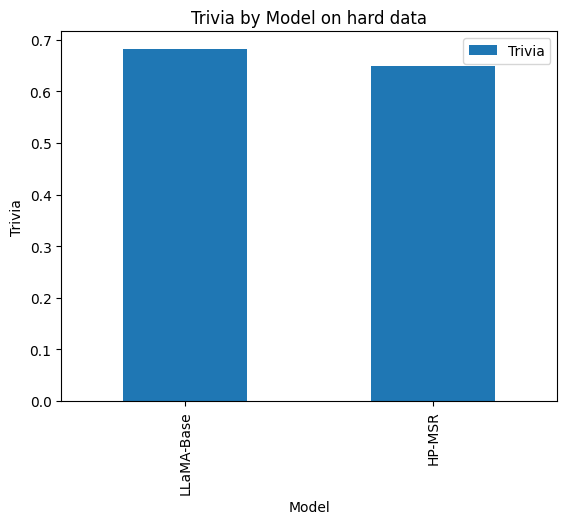

100%|██████████| 31/31 [01:22<00:00,  2.67s/it]


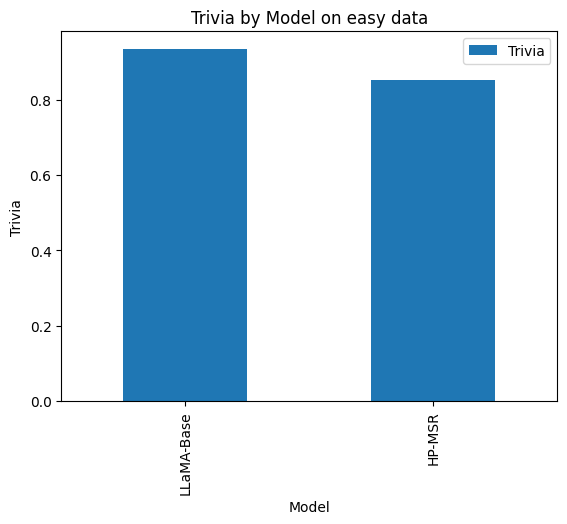

100%|██████████| 31/31 [01:23<00:00,  2.70s/it]


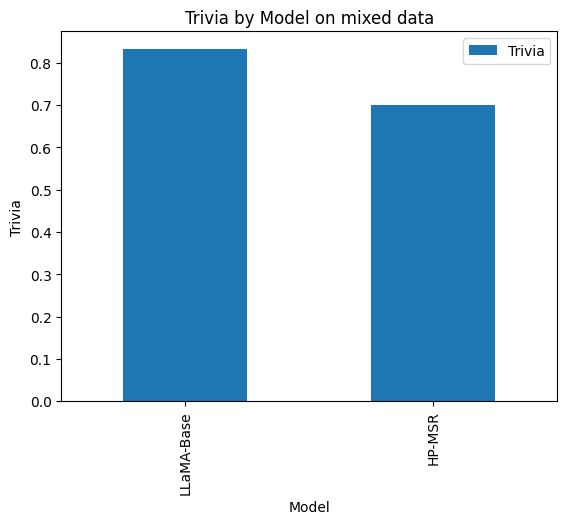

In [7]:
from tasks.hp.HPTask import HPTriviaTask
# hp = HPTriviaTask(batch_size=32, tokenizer=tokenizer, device='cuda', chat_model=True, randomize_answers=True)

# use_hard_data = False
trivia_dicts = {}
# data_type = "hard"
# for data_type in ["hard", "easy", "all"]:
#     if data_type == "hard":
#         train_data_location = "tasks/hp/data/hp_trivia_train_OLD.jsonl"
#         test_data_location = "tasks/hp/data/hp_trivia_test_OLD.jsonl"
#     elif data_type == "easy":
#         train_data_location = "tasks/hp/data/hp_trivia_train_NEW.jsonl"
#         test_data_location = "tasks/hp/data/hp_trivia_test_NEW.jsonl"
#     else:
#         train_data_location = "tasks/hp/data/hp_trivia_train.jsonl"
#         test_data_location = "tasks/hp/data/hp_trivia_test.jsonl"
data_type = "hard" # one of "easy", "hard", and "all"
for data_type in ["hard", "easy", "mixed"]:
    if data_type == "hard":
        data_loc = "tasks/hp/data/HARD_hp_trivia_1239.jsonl"
    elif data_type == "easy":
        data_loc = "tasks/hp/data/EASY_hp_trivia_1239.jsonl"
    else:
        data_loc = "tasks/hp/data/hp_trivia_1239.jsonl"

    trivia_dict = {}
    for model_name, model in models.items():
        hp_trivia_task = HPTriviaTask(batch_size=32, tokenizer=tokenizer, device='cuda', chat_model=True, randomize_answers=True, same_location=data_loc, train_n=1000) #train_data_location=train_data_location, test_data_location=test_data_location)

        n_test = len(hp_trivia_task.test_sentences)
        n_train = len(hp_trivia_task.train_sentences)

        # trivia_dict[model_name] = 
        test_accuracy = hp_trivia_task.get_test_accuracy(model, use_test_data=True, check_all_logits=False, n_iters=n_test // 32)
        train_accuracy = hp_trivia_task.get_test_accuracy(model, use_test_data=False, check_all_logits=False, n_iters=n_train // 32)

        trivia_dict[model_name] = (n_train*train_accuracy + n_test*test_accuracy) / (n_train + n_test)


    # with open(f"{save_dir}/trivia_dict_{data_type=}.pkl", "wb") as f:
    #     pickle.dump(trivia_dict, f)

    # Convert the dictionary to a pandas DataFrame
    baq_df = pd.DataFrame(list(trivia_dict.items()), columns=['Model', 'Trivia'])
    # Plot the bar graph
    baq_df.plot(kind='bar', x='Model', y='Trivia', legend=True)
    plt.ylabel('Trivia')
    plt.title(f'Trivia by Model on {data_type} data')
    plt.show()
    trivia_dicts[data_type] = trivia_dict

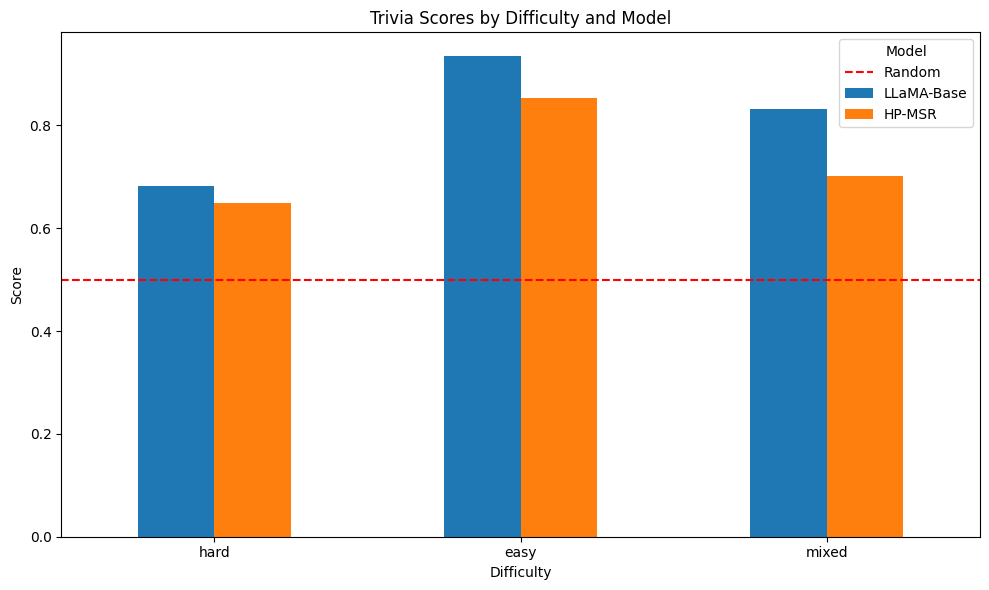

In [8]:
import pandas as pd
import matplotlib.pyplot as plt

# Your nested dictionary
data = trivia_dicts

save_dir = "results/final_paper_results"
with open(f"{save_dir}/trivia_dict.pkl", "wb") as f:
    pickle.dump(trivia_dicts, f)

# Convert the nested dictionary to a DataFrame
df = pd.DataFrame(data).T

# Plot
df.plot(kind='bar', figsize=(10, 6))
plt.title('Trivia Scores by Difficulty and Model')
plt.ylabel('Score')
plt.xlabel('Difficulty')
plt.xticks(rotation=0)
plt.axhline(y=0.5, color='r', linestyle='--', label='Random')
plt.legend(title='Model')
plt.tight_layout()
plt.show()

## SAQ Evals
Short answer questions about Harry Potter

In [18]:
from tasks.hp.HPSAQ import HPSAQ
from datetime import datetime
save_gens = True

if save_gens:
    exp_time = datetime.now().strftime("%a-%b%-d-%H%M")
    save_path_fn = lambda model_name: f'aengus_testing/datasets/{model_name}-short-familiarity-completions-evaluated-{exp_time}.jsonl'
else:
    save_path_fn = lambda model_name: None

saq_dict = {}
for model_name, model in models.items():
    hp_saq_task = HPSAQ()

    hp_saq_task.generate_responses(model, tokenizer, save_path=save_path_fn(model_name), eval_onthe_fly=True, max_new_tokens=20, temperature=0, verbose=True, eval_model=eval_model)

    saq_dict[model_name] = hp_saq_task.get_accuracies() # returns dict of ["zero_shot": int, "unrelated_few_shot": int, "few_shot": int]

with open(f"{save_dir}/saq_dict.pkl", "wb") as f:
    pickle.dump(saq_dict, f)

# Convert the dictionary to a pandas DataFrame
saq_df = pd.DataFrame(list(saq_dict.items()), columns=['Model', 'SAQ'])
# Plot the bar graph
saq_df.plot(kind='bar', x='Model', y='SAQ', legend=True)
plt.ylabel('SAQ')
plt.title('SAQ by Model')
plt.show()




Question 1/100 -- Time: 23:43:54


TypeError: HookedTransformer.generate() got an unexpected keyword argument 'return_dict_in_generate'

## Verbatim Evals
Completing sentences from Harry Potter

In [8]:
from tasks import HPVerbatimTask


verbatim_dict = {}
for model_name, model in models.items():

    temp_criterion_dict = {}
    for criterion in tqdm(["cross_entropy", "levenshtein", "accuracy"]):

        hp_verbatim_task = HPVerbatimTask(batch_size=32, tokenizer=tokenizer, device='cuda', criterion=criterion)
        result = hp_verbatim_task.get_test_loss(model, n_iters=5)
        if hasattr(result, "item"):
            result = result.item()
        temp_criterion_dict[criterion] = result
    verbatim_dict[model_name] = temp_criterion_dict

# save_dir = "results/final_paper_results"
with open(f"{save_dir}/verbatim_dict.pkl", "wb") as f:
    pickle.dump(verbatim_dict, f)

100%|██████████| 3/3 [01:07<00:00, 22.41s/it]


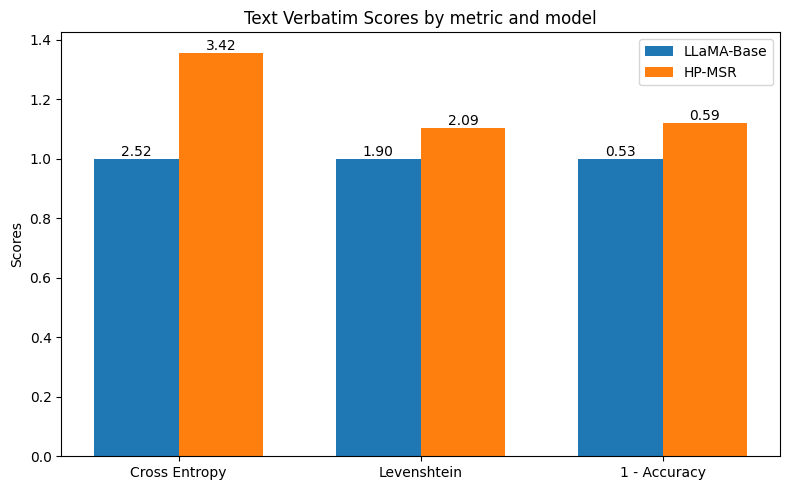

In [18]:
import matplotlib.pyplot as plt
import numpy as np

with open(f"{save_dir}/verbatim_dict.pkl", "rb") as f:
    verbatim_dict = pickle.load(f)

data = verbatim_dict
# change "accuracy" to "1 - accuracy" for better display
for model in data:
    data[model]["1 - accuracy"] = 1 - data[model].pop("accuracy")

# Your nested dictionaries
better_names = {"cross_entropy": "Cross Entropy", "levenshtein": "Levenshtein", "1 - accuracy": "1 - Accuracy"}

# Normalize HP-MSR values relative to LLaMA-Base values
normalized_data = {}
for metric in data['LLaMA-Base']:
    llama_value = data['LLaMA-Base'][metric]
    hp_value = data['HP-MSR'][metric]
    normalized_hp_value = (hp_value / llama_value) * 1.0  # Normalize HP-MSR to LLaMA-Base scale
    normalized_data[metric] = {'LLaMA-Base': 1.0, 'HP-MSR': normalized_hp_value}  # LLaMA-Base is set to 1.0 as per requirement

# Plotting
fig, ax = plt.subplots(figsize=(8, 5))
metrics = list(normalized_data.keys())
x = np.arange(len(metrics))  # the label locations
width = 0.35  # the width of the bars

for i, metric in enumerate(metrics):
    llama_base_height = normalized_data[metric]['LLaMA-Base']
    hp_msr_height = normalized_data[metric]['HP-MSR']
    ax.bar(x[i] - width/2, llama_base_height, width, label='LLaMA-Base' if i == 0 else "", color='C0')
    ax.bar(x[i] + width/2, hp_msr_height, width, label='HP-MSR' if i == 0 else "", color='C1')
    
    # Annotate actual values
    ax.text(x[i] - width/2, llama_base_height, f"{data['LLaMA-Base'][metric]:.2f}", ha='center', va='bottom')
    ax.text(x[i] + width/2, hp_msr_height, f"{data['HP-MSR'][metric]:.2f}", ha='center', va='bottom')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scores')
ax.set_title('Text Verbatim Scores by metric and model')
ax.set_xticks(x)
ax.set_xticklabels([better_names[metric] for metric in metrics])
ax.legend()

plt.tight_layout()
plt.show()

# Adversarial Attacks
Testing modifications to prompt and question style to see if we can get unlearned models better or base models worse. Testing only on original Harry Potter eval method.

In [ ]:
use_short = False
if use_short:
    eval_path = 'tasks/hp/data/msr_data/evaluation_prompts_short.json'
else:
    eval_path = 'tasks/hp/data/msr_data/evaluation_prompts.json'

from hp_utils.test_adversarial import test_dan_prompts, test_summary_styles, test_base_unlrn_prompts, test_text_lines
def get_familiarity_score(adversarial_task, model):
    adversarial_task.generate_responses(model, tokenizer, save_path=None, eval_onthe_fly=False, max_new_tokens=20, temperature=0, verbose=True)
    adversarial_task.run_model_evals(eval_model=eval_model, max_eval_tokens=None, save_path=None)
    familiarity, responses = adversarial_task.get_accuracies()
    # return familiarity
    return responses

def show_df(df):
    # Replace None with 'None' in the index
    df.index = df.index.fillna('None')
    
    # Melt the DataFrame to a long format for easier plotting
    df = df.reset_index().melt(id_vars='index', var_name='Model', value_name='Familiarity')

    # Plot the bar graph
    df.groupby(['index', 'Model']).sum().unstack().plot(kind='bar', legend=True)

    plt.ylabel('Familiarity')

  0%|          | 0/300 [00:00<?, ?it/s]/data/phillip_guo/miniconda3/envs/hp-unlrn/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:389: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/data/phillip_guo/miniconda3/envs/hp-unlrn/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:394: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
100%|██████████| 300/300 [02:31<00:00,  1.98it/s]


Error in getting model grade, returning -100
Error in getting model grade, returning -100
Error in getting model grade, returning -100
Error in getting model grade, returning -100
Error in getting model grade, returning -100
Error in getting model grade, returning -100
Error in getting model grade, returning -100
Error in getting model grade, returning -100
Error in getting model grade, returning -100
Error in getting model grade, returning -100
Error in getting model grade, returning -100
Error in getting model grade, returning -100
Error in getting model grade, returning -100
Error in getting model grade, returning -100
Error in getting model grade, returning -100
Error in getting model grade, returning -100
Error in getting model grade, returning -100
Error in getting model grade, returning -100


300it [00:00, 986121.63it/s]


defaultdict(<class 'int'>, {1: 20, 0: 158, 3: 83, -100: 18, 2: 21})


  0%|          | 0/300 [00:00<?, ?it/s]/data/phillip_guo/miniconda3/envs/hp-unlrn/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:389: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
100%|██████████| 300/300 [02:30<00:00,  2.00it/s]


Error in getting model grade, returning -100
Error in getting model grade, returning -100
Error in getting model grade, returning -100
Error in getting model grade, returning -100
Error in getting model grade, returning -100
Error in getting model grade, returning -100
Error in getting model grade, returning -100
Error in getting model grade, returning -100
Error in getting model grade, returning -100
Error in getting model grade, returning -100
Error in getting model grade, returning -100
Error in getting model grade, returning -100
Error in getting model grade, returning -100
Error in getting model grade, returning -100
Error in getting model grade, returning -100
Error in getting model grade, returning -100
Error in getting model grade, returning -100
Error in getting model grade, returning -100
Error in getting model grade, returning -100
Error in getting model grade, returning -100
Error in getting model grade, returning -100
Error in getting model grade, returning -100
Error in g

300it [00:00, 845057.89it/s]

defaultdict(<class 'int'>, {-100: 27, 0: 191, 3: 37, 1: 29, 2: 16})


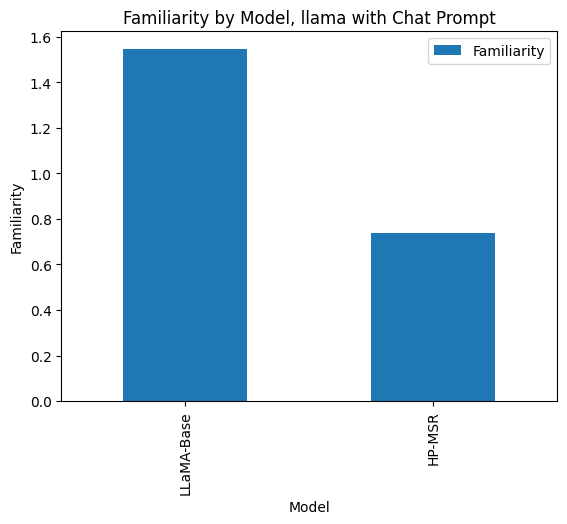

In [ ]:
from tasks.hp.HPAdversarialTask import HPCompletionsFamiliarityAdversarial
save_gens = False
use_short = False

if save_gens:
    exp_time = datetime.now().strftime("%a-%b%-d-%H%M")
    save_path_fn = lambda model_name: f'aengus_testing/datasets/{model_name}-{use_short=}-familiarity-completions-evaluated-{exp_time}.jsonl'
else:
    save_path_fn = lambda model_name: None

chat_familiarity_dict = {}
for model_name, model in models.items():
    hp_familiarity_task = HPCompletionsFamiliarityAdversarial(dataset_path='tasks/hp/data/msr_data/evaluation_prompts_short.json' if use_short else 'tasks/hp/data/msr_data/evaluation_prompts.json')

    hp_familiarity_task.generate_responses(model, tokenizer, save_path=save_path_fn(model_name), eval_onthe_fly=False, max_new_tokens=20, temperature=0, verbose=True)
    hp_familiarity_task.run_model_evals(eval_model=eval_model, max_eval_tokens=None, save_path=save_path_fn(model_name))

    familiarity, responses = hp_familiarity_task.get_accuracies()
    print(responses)
    chat_familiarity_dict[model_name] = responses

with open(f"{save_dir}/chat_familiarity_dict.pkl", "wb") as f:
    pickle.dump(chat_familiarity_dict, f)

# # Convert the dictionary to a pandas DataFrame
# chat_familiarity_df = pd.DataFrame(list(chat_familiarity_dict.items()), columns=['Model', 'Familiarity'])

# # Plot the bar graph
# chat_familiarity_df.plot(kind='bar', x='Model', y='Familiarity', legend=True)
# plt.ylabel('Familiarity')
# plt.title('Familiarity by Model, llama with Chat Prompt')
# plt.show()

## Languages
Should test languages on familiarity evals, still in progress

  0%|          | 0/300 [00:00<?, ?it/s]/data/phillip_guo/miniconda3/envs/hp-unlrn/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:389: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/data/phillip_guo/miniconda3/envs/hp-unlrn/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:394: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
100%|██████████| 300/300 [02:26<00:00,  2.05it/s]


Error in getting model grade, returning -100
Error in getting model grade, returning -100
Error in getting model grade, returning -100


100%|██████████| 300/300 [02:17<00:00,  2.19it/s]


Error in getting model grade, returning -100


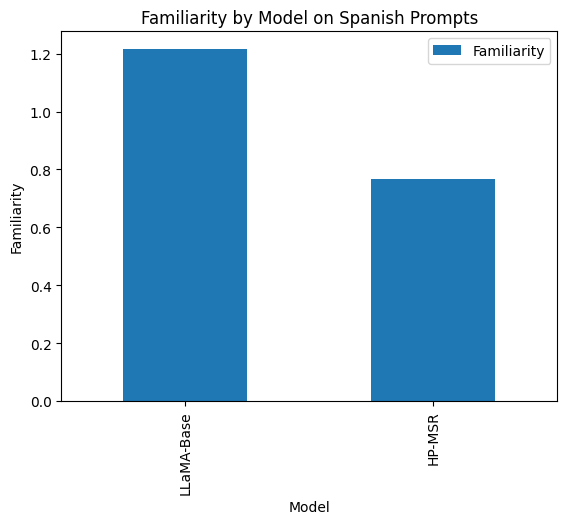

In [6]:
# from tasks.hp.HPTranslatedTask import HPCompletionsFamiliaritySpanish

if save_gens:
    exp_time = datetime.now().strftime("%a-%b%-d-%H%M")
    save_path_fn = lambda model_name: f'aengus_testing/datasets/{model_name}-spanish-{use_short=}-familiarity-completions-evaluated-{exp_time}.jsonl'
else:
    save_path_fn = lambda model_name: None

spanish_familiarity_dict = {}
for model_name, model in models.items():
    hp_familiarity_task = HPCompletionsFamiliarity(dataset_path='tasks/hp/data/msr_data/evaluation_spanish_prompts_short.json' if use_short else 'tasks/hp/data/msr_data/evaluation_spanish_prompts.json')

    hp_familiarity_task.generate_responses(model, tokenizer, save_path=save_path_fn(model_name), eval_onthe_fly=False, max_new_tokens=20, temperature=0, verbose=True)
    hp_familiarity_task.run_model_evals(eval_model=eval_model, max_eval_tokens=None, save_path=save_path_fn(model_name))

    familiarity, responses = hp_familiarity_task.get_accuracies()
    spanish_familiarity_dict[model_name] = responses

# Convert the dictionary to a pandas DataFrame
familiarity_df = pd.DataFrame(list(spanish_familiarity_dict.items()), columns=['Model', 'Familiarity'])

with open(f'{save_dir}/spanish_familiarity_dict.pkl', 'wb') as f:
    pickle.dump(spanish_familiarity_dict, f)

# Plot the bar graph
# familiarity_df.plot(kind='bar', x='Model', y='Familiarity', legend=True)
# plt.ylabel('Familiarity')
# plt.title('Familiarity by Model on Spanish Prompts')
# plt.show()


## DAN Prompts
Prompts that try to trigger Harry Potter knowledge in the model without actual knowledge of Harry Potter

  0%|          | 0/2 [00:00<?, ?it/s]/opt/conda/envs/hp-unlrn/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:392: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
100%|██████████| 20/20 [00:14<00:00,  1.40it/s]


Error in getting model grade, returning -100
Error in getting model grade, returning -100
Error in getting model grade, returning -100
Error in getting model grade, returning -100


20it [00:00, 120525.98it/s]
100%|██████████| 20/20 [00:14<00:00,  1.37it/s]


Error in getting model grade, returning -100
Error in getting model grade, returning -100
Error in getting model grade, returning -100


20it [00:00, 143886.93it/s]
100%|██████████| 2/2 [08:11<00:00, 245.51s/it]


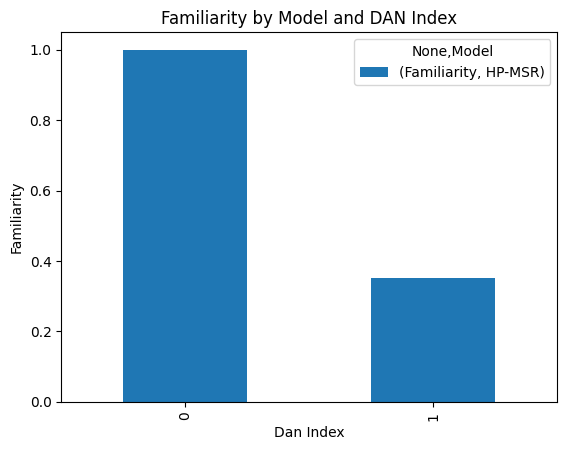

In [6]:
from tasks.hp.HPAdversarialTask import HPCompletionsFamiliarityAdversarial

dan_adversarial_dict = {model_name: {} for model_name in models.keys()}
for model_name, model in models.items():
    dan_adversarial_dict[model_name] = test_dan_prompts(model, HPCompletionsFamiliarityAdversarial, get_familiarity_score, dataset_path=eval_path)

with open(f"{save_dir}/dan_adversarial_dict.pkl", "wb") as f:
    pickle.dump(dan_adversarial_dict, f)
    
# dan_adversarial_df = pd.DataFrame(dan_adversarial_dict)
# show_df(dan_adversarial_df)
# plt.xlabel('Dan Index')
# plt.title('Familiarity by Model and DAN Index')
# plt.show()

## In Context Relearning
Prompts that give either a summary or lines of text to the model in a system prompt to trigger Harry Pottre knowledge

  0%|          | 0/3 [00:00<?, ?it/s]/data/phillip_guo/miniconda3/envs/hp-unlrn/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:389: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/data/phillip_guo/miniconda3/envs/hp-unlrn/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:394: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
100%|██████████| 300/300 [02:29<00:00,  2.00it/s]


Error in getting model grade, returning -100


100%|██████████| 300/300 [03:00<00:00,  1.66it/s]


Error in getting model grade, returning -100


100%|██████████| 3/3 [16:10<00:00, 323.59s/it]


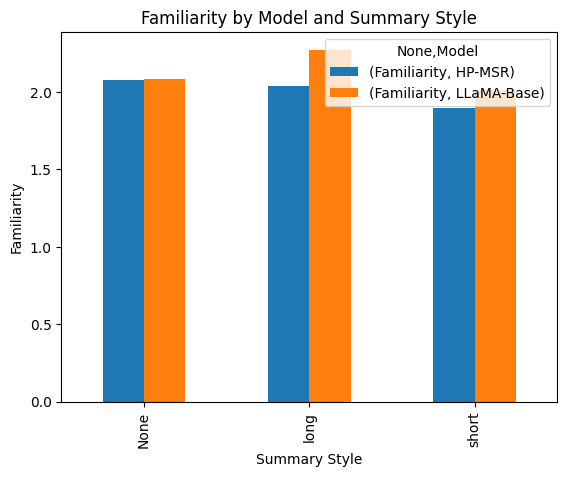

In [8]:
# Giving summaries in prompt
summary_style_dict = {model_name: {} for model_name in models.keys()}

for model_name, model in models.items():
    summary_style_dict[model_name] = test_summary_styles(model, HPCompletionsFamiliarityAdversarial, get_familiarity_score, dataset_path=eval_path)

with open(f"{save_dir}/summary_style_dict.pkl", "wb") as f:
    pickle.dump(summary_style_dict, f)
    
# summary_style_df = pd.DataFrame(summary_style_dict)
# show_df(summary_style_df)
# plt.xlabel('Summary Style')
# plt.title('Familiarity by Model and Summary Style')
# plt.show()

In [9]:
# Lines of text
text_lines_dict = {model_name: {} for model_name in models.keys()}
for model_name, model in models.items():
    text_lines_dict[model_name] = test_text_lines(model, HPCompletionsFamiliarityAdversarial, get_familiarity_score, dataset_path=eval_path)

with open(f"{save_dir}/text_lines_dict.pkl", "wb") as f:
    pickle.dump(text_lines_dict, f)

# text_lines_df = pd.DataFrame(text_lines_dict)
# show_df(text_lines_df)
# plt.xlabel('Lines of Text')
# plt.title('Familiarity by Model and Lines of Text')
# plt.show()

  0%|          | 0/5 [00:00<?, ?it/s]/data/phillip_guo/miniconda3/envs/hp-unlrn/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:389: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/data/phillip_guo/miniconda3/envs/hp-unlrn/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:394: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
100%|██████████| 300/300 [02:30<00:00,  1.99it/s]


Error in getting model grade, returning -100
Error in getting model grade, returning -100


100%|██████████| 300/300 [02:32<00:00,  1.97it/s]


Error in getting model grade, returning -100
Error in getting model grade, returning -100


100%|██████████| 300/300 [02:38<00:00,  1.89it/s]


Error in getting model grade, returning -100
Error in getting model grade, returning -100


100%|██████████| 300/300 [03:07<00:00,  1.60it/s]


Error in getting model grade, returning -100
Error in getting model grade, returning -100
Error in getting model grade, returning -100
Error in getting model grade, returning -100


100%|██████████| 300/300 [03:22<00:00,  1.48it/s]


Error in getting model grade, returning -100
Error in getting model grade, returning -100


 20%|██        | 1/5 [07:29<29:58, 449.69s/it]


KeyboardInterrupt: 

## Baseline Unlearning Prompt
Prompts that try to get the model to unlearn Harry Potter knowledge

  0%|          | 0/6 [00:00<?, ?it/s]/data/phillip_guo/miniconda3/envs/hp-unlrn/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:389: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/data/phillip_guo/miniconda3/envs/hp-unlrn/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:394: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(


100%|██████████| 6/6 [21:16<00:00, 212.68s/it]


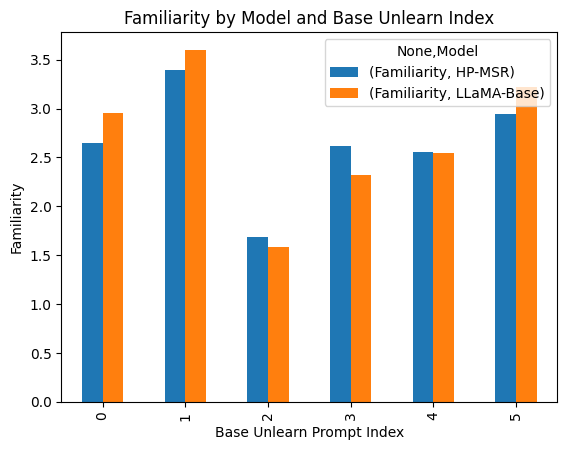

In [ ]:
base_unlrn_dict = {model_name: {} for model_name in models.keys()}
for model_name, model in models.items():
    base_unlrn_dict[model_name] = test_base_unlrn_prompts(model, HPCompletionsFamiliarityAdversarial, get_familiarity_score, dataset_path=eval_path)
with open(f"{save_dir}/base_unlrn_dict.pkl", "wb") as f:
    pickle.dump(base_unlrn_dict, f)
base_unlrn_df = pd.DataFrame(base_unlrn_dict)

# show_df(base_unlrn_df)
# plt.xlabel('Base Unlearn Prompt Index')
# plt.title('Familiarity by Model and Base Unlearn Index')
# plt.show()

# Graph Everything

In [99]:
import pickle
from collections import defaultdict
save_dir = "results/final_paper_results"

def get_familiarity_score(dict):
    try:
        overall_dict = {}
        for key in dict:
            total_responses = dict[key].get(0) + dict[key].get(1) + dict[key].get(2) + dict[key].get(3)
            total_correct = dict[key].get(2) + 5 * dict[key].get(3)
            overall_dict[key] = total_correct / total_responses
        return overall_dict
    except: # not nested
        for key in dict:
            total_responses = dict[0] + dict[1] + dict[2] + dict[3]
            total_correct = dict[2] + 5 * dict[3]
            return total_correct / total_responses
    
def process_temp_dict(save_dir, save_dict):
    with open(save_dir, "rb") as f:
        temp_familiarity_dict = pickle.load(f)
    for key in temp_familiarity_dict:
        if key not in save_dict:
            save_dict[key] = get_familiarity_score(temp_familiarity_dict[key])
        else:
            print("key")

In [100]:
familiarity_dict = {}
# trivia_dict = {}
# saq_dict = {}
# verbatim_dict = {}
# spanish_familiarity_dict = {}
chat_familiarity_dict = {}
dan_adversarial_dict = {}
summary_style_dict = {}
text_lines_dict = {}
base_unlrn_dict = {}


for save_path in ['results/llama-only-results-gpt4', 'results/hp-only-results-gpt4']:
    for temp_save_dir, temp_save_dict in zip([f'{save_path}/base_unlrn_dict.pkl', f'{save_path}/text_lines_dict.pkl', f'{save_path}/summary_style_dict.pkl', f'{save_path}/dan_adversarial_dict.pkl',f'{save_path}/familiarity_dict.pkl', f'{save_path}/chat_familiarity_dict.pkl'], [base_unlrn_dict, text_lines_dict, summary_style_dict, dan_adversarial_dict, familiarity_dict, chat_familiarity_dict]):
        process_temp_dict(temp_save_dir, temp_save_dict)

language_familiarity_dict = {}
process_temp_dict(f"{save_dir}/language_familiarity_dict_processed.pkl", language_familiarity_dict)



In [ ]:
{
    "hp_model": {
        "british_mythology_familiarity": [2.1, {"0": 27, "3": 21, "1": 2}],
        "harry_potter_film_production_familiarity": [1.0, {"3": 9, "0": 34, "1": 2}],
        "dungeons_and_dragons_familiarity": [0.94, {"3": 9, "0": 35, "2": 2, "1": 4}],
        "lord_of_the_rings_familiarity": [1.32, {"0": 33, "3": 13, "1": 3, "2": 1}],
        "wizard_of_oz_familiarity": [0.0, {"0": 50}]
    },
    "regular_model": {
        "british_mythology_familiarity": [2.22, {"0": 25, "3": 22, "2": 1, "1": 2}],
        "harry_potter_film_production_familiarity": [2.0, {"3": 18, "0": 25, "1": 2}],
        "dungeons_and_dragons_familiarity": [0.94, {"2": 2, "0": 33, "3": 9, "1": 6}],
        "lord_of_the_rings_familiarity": [2.7, {"0": 23, "3": 27}],
        "wizard_of_oz_familiarity": [0.2, {"0": 48, "3": 2}]
    }
}

Using LLaMA-Base for Llama-2
Using LLaMA-Base for Llama-2
Using LLaMA-Base for Llama-2
Using LLaMA-Base for Llama-2
Using LLaMA-Base for Llama-2
Using LLaMA-Chat for Llama-2
Using LLaMA-Chat for Llama-2


/tmp/ipykernel_160721/3865082862.py:102: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax.annotate(f'Δ -{delta*100:.0f}%', xy=(i, pivot_df['Llama-2'][i] + 0.01), ha='center', color=color)
/tmp/ipykernel_160721/3865082862.py:103: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax.annotate('', xy=(i + 0.1, pivot_df["Llama-2"][i]), xytext=(i + 0.1, pivot_df['WHP'][i]), arrowprops=dict(arrowstyle='<|-|>', color=color))


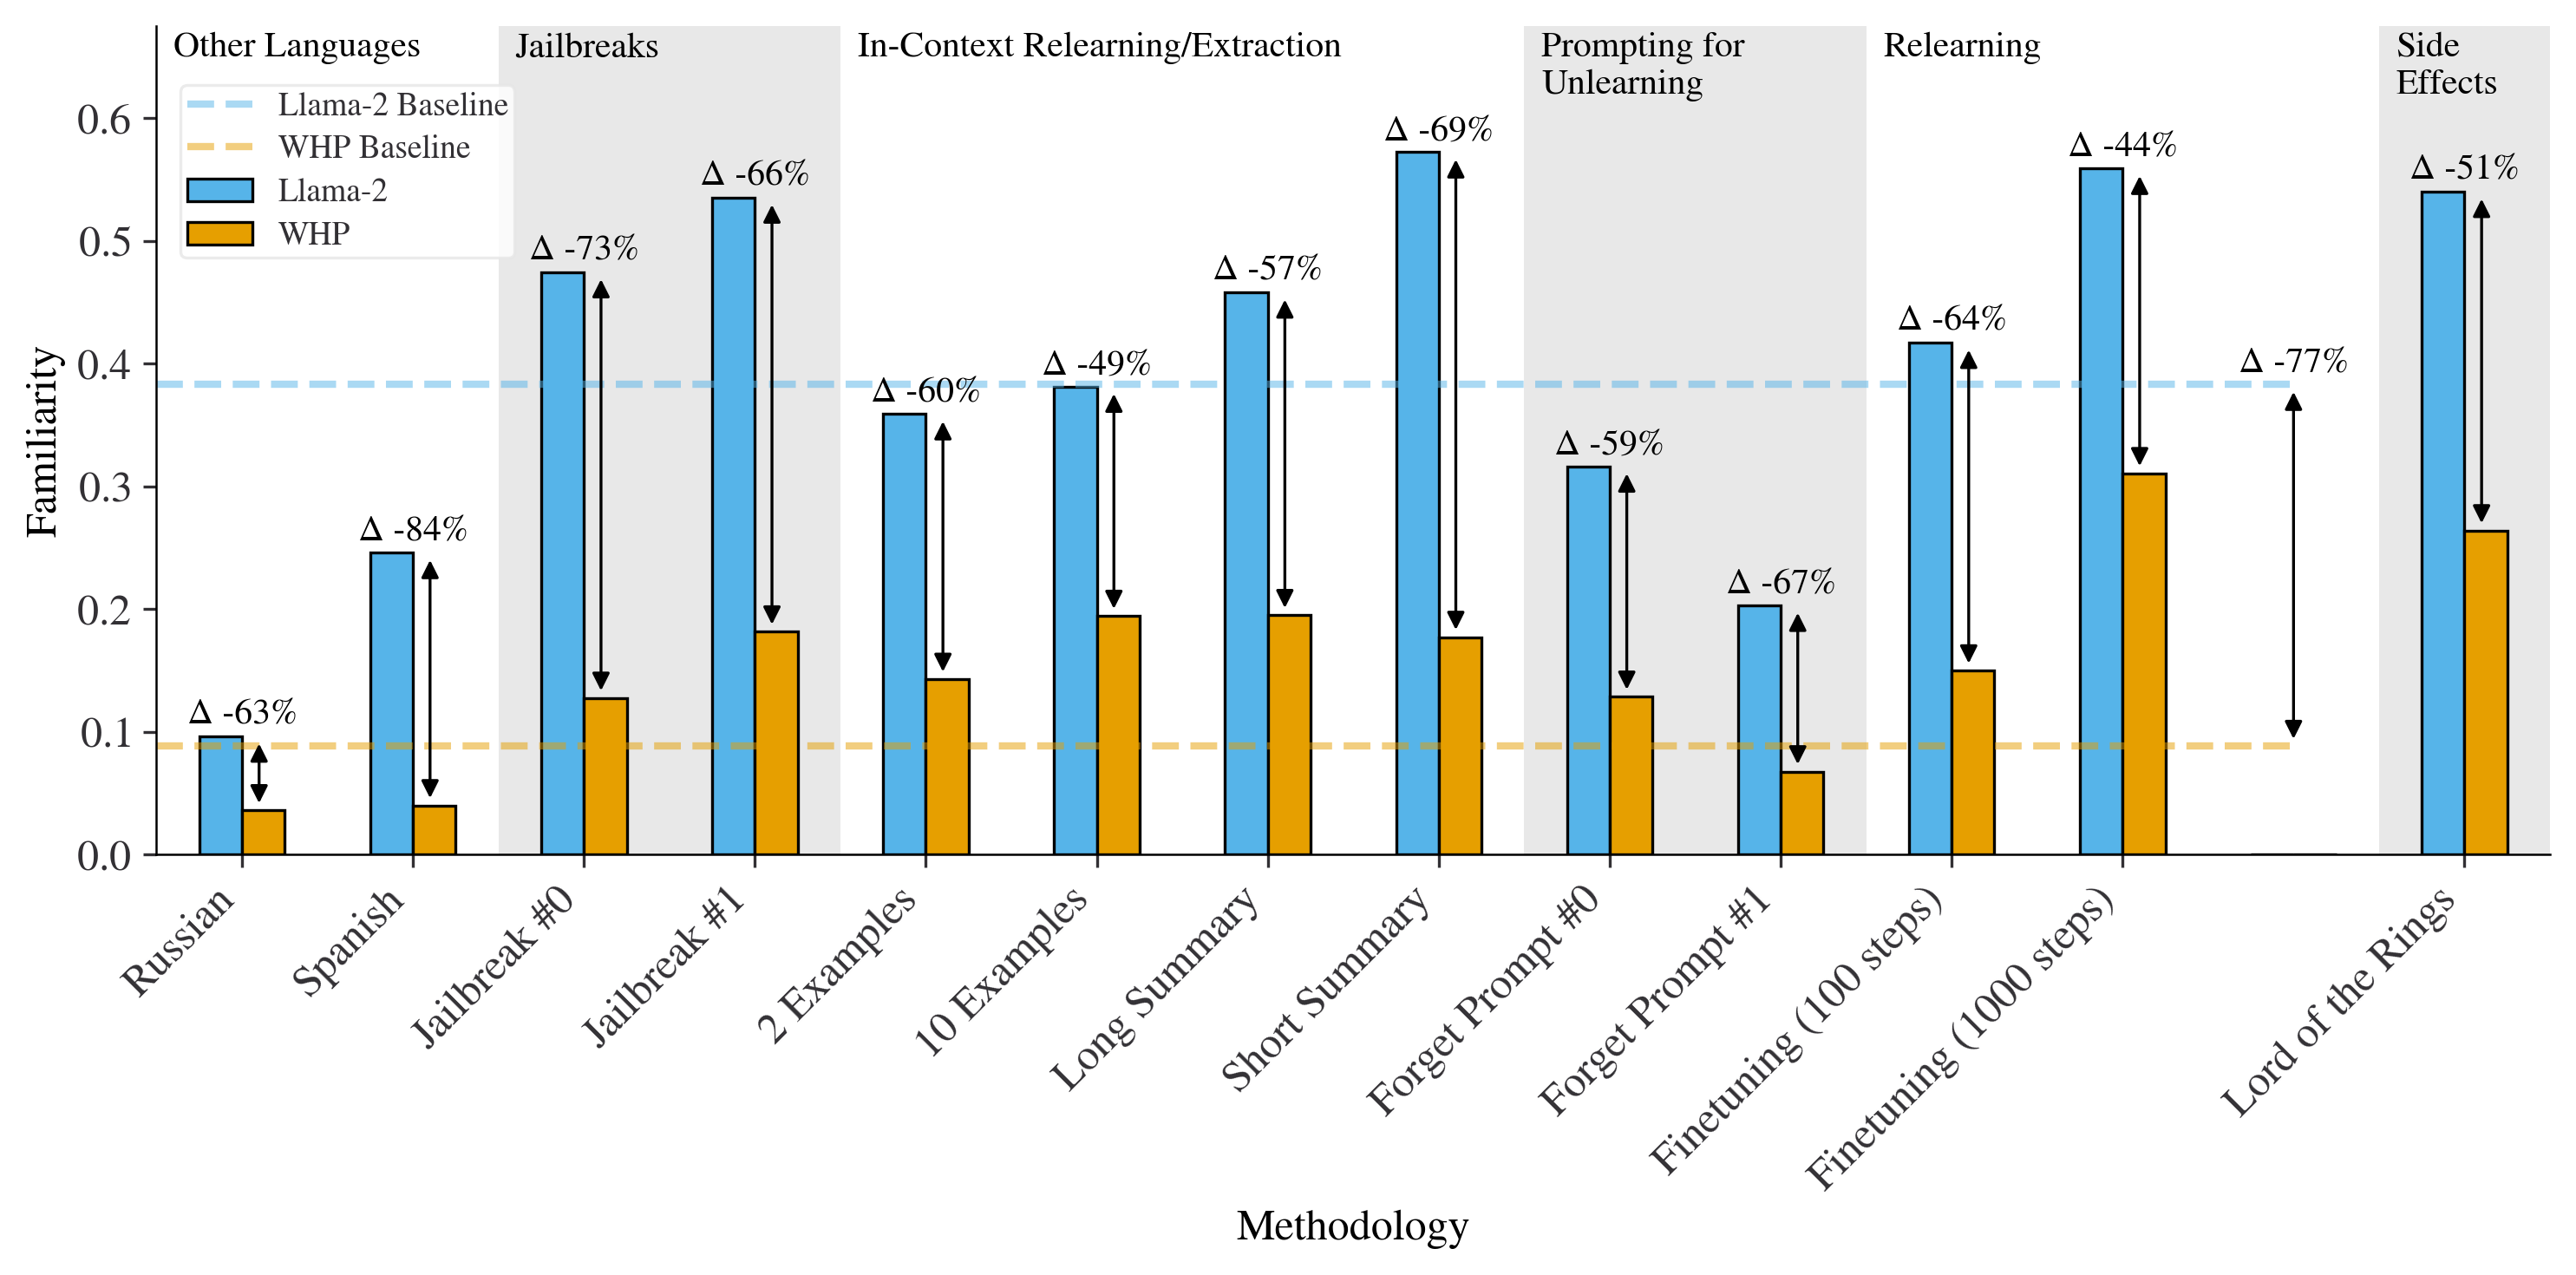

In [176]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

lotr_data = {
    "LLaMA-Chat": 2.7,
    "HP-MSR": 1.32,
}

ft_data = {
    "LLaMA-Chat": {
        100: 2.0850340136054424,
        1000: 2.793918918918919,
    },
    "HP-MSR": {
        100: 0.7491408934707904,
        1000: 1.5528169014084507,
    },
}

# Use the plot style from the file
plt.style.use('plot_style.txt')

color_dict = {"Llama-2": 'C1', 'WHP': 'C0'}
model_order = ['Llama-2', 'WHP']

data_model_names = {'Llama-2': ('LLaMA-Base', 'LLaMA-Chat'), 'WHP': 'HP-MSR'}
plot_model_names = {'LLaMA-Base': 'Llama-2', 'LLaMA-Chat': 'Llama-2', 'HP-MSR': 'WHP'}

def process_label(methodology, style):
    if methodology == "E":
        return f"Forget Prompt #{style}"
    elif methodology == "B":
        return f"Jailbreak #{style}"
    elif methodology == "A":
        return f"{style}"
    elif methodology == "D":
        if style == "short":
            return "Short Summary"
        elif style == "long":
            return "Long Summary"
    elif methodology == "C":
        return f"{style} Examples"
    elif methodology == "F":
        return f"Finetuning ({style} steps)"
    elif methodology == "G":
        return f"Lord of the Rings"

# Combine all dictionaries into a single DataFrame
data = []
for name, dict_ in [("A", language_familiarity_dict),
                    ("B", dan_adversarial_dict),
                    ("C", text_lines_dict), 
                    ("D", summary_style_dict), 
                    ("E", base_unlrn_dict),
                    ("F", ft_data),
                    ("G", lotr_data)]:
    for model in model_order:
        true_data_name = data_model_names[model]
        if isinstance(true_data_name, tuple):
            for data_name in true_data_name:
                if data_name in dict_:
                    true_data_name = data_name
                    print(f"Using {true_data_name} for {model}")
                    break
        try:
            scores = dict_[true_data_name]
        except:
            print(dict_)
        if isinstance(scores, dict):
            for eval_style, score in scores.items():
                if eval_style == 'English' and name == "A":
                    continue
                data.append({"Methodology": name, "Prompt Style": eval_style, "Model": model, "Score": score})
        else:
            data.append({"Methodology": name, "Prompt Style": "Chat", "Model": model, "Score": scores})

data.append({"Methodology": "FA", "Prompt Style": "", "Model": "Llama-2", "Score": 0})
data.append({"Methodology": "FA", "Prompt Style": "", "Model": "WHP", "Score": 0})

df = pd.DataFrame(data)

# Specify the order of models here
# Ensure the Model column is of category type and ordered as specified

# Plotting
fig, ax = plt.subplots(figsize=(10, 5))

pivot_df = df.pivot_table(index=["Methodology", "Prompt Style"], columns='Model', values='Score')

pivot_df /= 5
# familiarity_dict = {model: score / 5 for model, score in familiarity_dict.items()}

# Compute the differences and add them to the plot
deltas = pivot_df["Llama-2"] - pivot_df['WHP']
deltas /= pivot_df["Llama-2"]
for i, delta in enumerate(deltas):
    if i == 12:
        continue

    color = "black"
    ax.annotate(f'Δ -{delta*100:.0f}%', xy=(i, pivot_df['Llama-2'][i] + 0.01), ha='center', color=color)
    ax.annotate('', xy=(i + 0.1, pivot_df["Llama-2"][i]), xytext=(i + 0.1, pivot_df['WHP'][i]), arrowprops=dict(arrowstyle='<|-|>', color=color))

# Plot each methodology as a separate group
pivot_df.plot(kind='bar', ax=ax, color=[color_dict[model] for model in pivot_df.columns])

# add colored backgrounds to group cols

group_sizes = [2, 2, 4, 2, 3, 1]

# add striped backgrounds

start_loc = 0

n_cols = 12
n_base_cols = 14

for i, group_size in enumerate(group_sizes):
    if i % 2 == 1:
        ax.axvspan(start_loc - 0.5, start_loc + group_size - 0.5, facecolor='lightgrey', alpha=0.5, zorder=0, edgecolor='none')
    start_loc += group_size

plt.xticks(labels=[process_label(methodology, style) for methodology, style in pivot_df.index if methodology != "FA"], ticks=[x for x in np.arange(len(pivot_df.index)) if x != 12])

plt.ylim(0,0.675)

scaled_familiarity_dict = {model: score / 5 for model, score in familiarity_dict.items()}

# Add horizontal lines for familiarity_dict
for model, score in scaled_familiarity_dict.items():
    plot_model_name = plot_model_names[model]
    # ax.axhline(y=score, linestyle="--", label=f"{plot_model_name} Familiarity", color=color_dict[plot_model_name], alpha=0.5)
    # add y-limits to the line
    ax.axhline(y=score, linestyle="--", label=f"{plot_model_name} Baseline", color=color_dict[plot_model_name], alpha=0.5, xmin=0, xmax=(n_cols+0.5)/n_base_cols)

familiarity_delta = (scaled_familiarity_dict['HP-MSR'] - scaled_familiarity_dict['LLaMA-Base']) / scaled_familiarity_dict['LLaMA-Base']

final_delta_xpos = 12

ax.annotate(f'Δ {familiarity_delta*100:.0f}%', xy=(final_delta_xpos, scaled_familiarity_dict['LLaMA-Base'] + 0.01), ha='center', color="black")
ax.annotate('', xy=(final_delta_xpos, scaled_familiarity_dict['LLaMA-Base']), xytext=(final_delta_xpos, scaled_familiarity_dict['HP-MSR']), arrowprops=dict(arrowstyle='<|-|>', color="black"))

# add label across first 2 columns

ax.annotate('Other Languages', xy=(-0.4, 0.65), ha='left', color="black")
ax.annotate("Jailbreaks", xy=(1.6, 0.65), ha='left', color="black")
ax.annotate("In-Context Relearning/Extraction", xy=(3.6, 0.65), ha='left', color="black")
ax.annotate("Prompting for\nUnlearning", xy=(7.6, 0.62), ha='left', color="black")
ax.annotate("Relearning", xy=(9.6, 0.65), ha='left', color="black")
ax.annotate("Side\nEffects", xy=(12.6, 0.62), ha='left', color="black")

plt.xlim(-0.5, n_base_cols - 0.5)

plt.ylabel('Familiarity')
plt.xlabel('Methodology')

# slightly smaller font size
plt.legend(loc=(0.01, 0.72), fontsize=9)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig("all_evals.svg")

In [102]:
with open(f"{save_dir}/verbatim_dict.pkl", "rb") as f:
    verbatim_dict = pickle.load(f)

    verbatim_types = ["cross_entropy"]
    verbatim_models = ["LLaMA-Base", "HP-MSR"]

    print(verbatim_dict)

    verbatim_dict = {plot_model_names[model]: {verbatim_type: verbatim_dict[model][verbatim_type] for verbatim_type in verbatim_types} for model in verbatim_models}

with open(f"{save_dir}/trivia_dict.pkl", "rb") as f:
    trivia_dict = pickle.load(f)

    print(trivia_dict)

    trivia_types = ["hard", "easy"]
    trivia_models = ["LLaMA-Base", "HP-MSR"]
    trivia_dict = {plot_model_names[model]: {trivia_type: trivia_dict[trivia_type][model] for trivia_type in trivia_types} for model in trivia_models}

saq_dict = {"Llama-2": {"few_shot": 0.2876712328767123}, "WHP": {"few_shot": 0.1718555417185554}}

{'LLaMA-Base': {'cross_entropy': 2.519650459289551, 'levenshtein': 1.897415041923523, 'accuracy': 0.4690881371498108}, 'HP-MSR': {'cross_entropy': 3.4175591468811035, 'levenshtein': 2.0918381214141846, 'accuracy': 0.4063777029514313}}
{'hard': {'LLaMA-Base': 0.6818522583992591, 'HP-MSR': 0.6490225737643335}, 'easy': {'LLaMA-Base': 0.9343881688815492, 'HP-MSR': 0.8531275686873985}, 'mixed': {'LLaMA-Base': 0.8325550559206732, 'HP-MSR': 0.7013313936837721}}


In [103]:
with open("results/final_paper_results/supervised_probes_results_1239_easy.pkl", "rb") as f:
    supervised_easy = pickle.load(f)["test_accs"]

with open("results/final_paper_results/supervised_probes_results_1239_hard.pkl", "rb") as f:
    supervised_hard = pickle.load(f)["test_accs"]

with open("results/final_paper_results/ccs_accuracies_1239_easy.pkl", "rb") as f:
    ccs_easy = pickle.load(f)["test_accuracies"]

with open("results/final_paper_results/ccs_accuracies_1239_hard.pkl", "rb") as f:
    ccs_hard = pickle.load(f)["test_accuracies"]

models = ["LLaMA-Base", "HP-MSR"]

# rename the models

supervised_easy = {plot_model_names[model]: acc for model, acc in supervised_easy.items()}
supervised_hard = {plot_model_names[model]: acc for model, acc in supervised_hard.items()}
ccs_easy = {plot_model_names[model]: acc for model, acc in ccs_easy.items()}
ccs_hard = {plot_model_names[model]: acc for model, acc in ccs_hard.items()}

for model in supervised_easy.keys():
    supervised_easy[model] = [(ckpt, acc) for ckpt, acc in enumerate(supervised_easy[model])]

for model in supervised_hard.keys():
    supervised_hard[model] = [(ckpt, acc) for ckpt, acc in enumerate(supervised_hard[model])]

for model in ccs_easy.keys():
    ccs_easy[model] = [(ckpt, acc) for ckpt, acc in ccs_easy[model].items()]

for model in ccs_hard.keys():
    ccs_hard[model] = [(ckpt, acc) for ckpt, acc in ccs_hard[model].items()]

hard    0.048148
easy    0.086967
dtype: float64
few_shot    0.402597
dtype: float64


/tmp/ipykernel_160721/2914237664.py:15: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  axs[1].annotate(f'Δ -{delta*100:.0f}%', xy=(i, trivia_df["Llama-2"][i] + 0.025), ha='center', color=color)
/tmp/ipykernel_160721/2914237664.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  axs[1].annotate('', xy=(i + 0.1, trivia_df["Llama-2"][i] + 0.005), xytext=(i + 0.1, trivia_df['WHP'][i] - 0.005), arrowprops=dict(arrowstyle='<|-|>', color=color))
/tmp/ipykernel_160721/2914237664.py:34: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as label

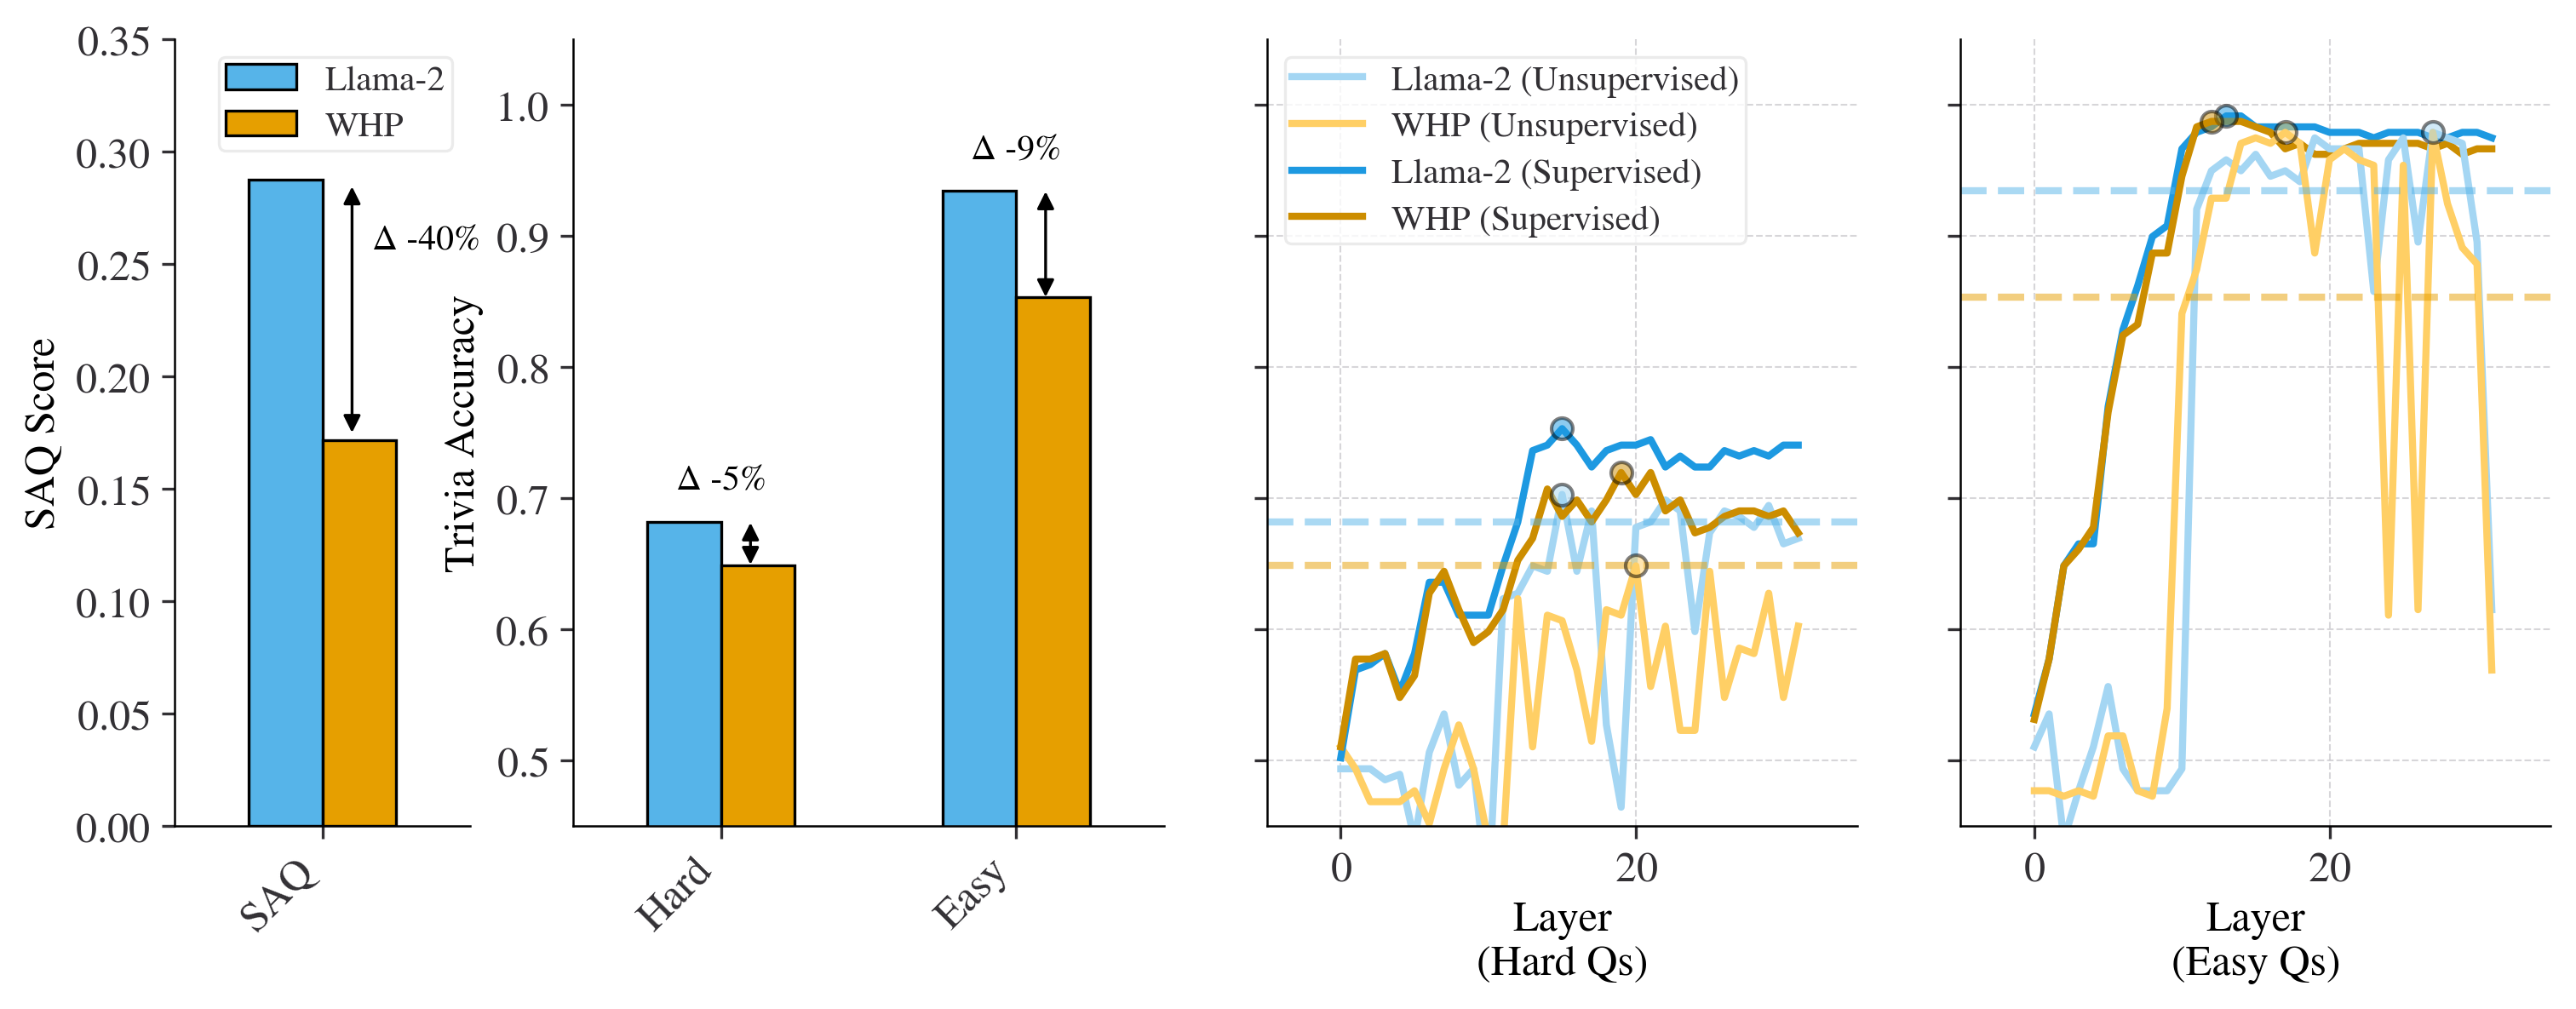

In [139]:
fig, axs = plt.subplots(figsize=(12,4), ncols=4, nrows=1, gridspec_kw={'width_ratios': [1, 2, 2, 2]})

# Plot the trivia scores
trivia_df = pd.DataFrame(trivia_dict)

trivia_df.plot(kind='bar', ax=axs[1], color=[color_dict[model] for model in trivia_df.columns], legend=False)

deltas = trivia_df["Llama-2"] - trivia_df['WHP']
deltas /= trivia_df["Llama-2"]

print(deltas)

for i, delta in enumerate(deltas):
    color = "black"
    axs[1].annotate(f'Δ -{delta*100:.0f}%', xy=(i, trivia_df["Llama-2"][i] + 0.025), ha='center', color=color)
    axs[1].annotate('', xy=(i + 0.1, trivia_df["Llama-2"][i] + 0.005), xytext=(i + 0.1, trivia_df['WHP'][i] - 0.005), arrowprops=dict(arrowstyle='<|-|>', color=color))

axs[1].set_ylabel('Trivia Accuracy')

# slant the x-axis labels
axs[1].set_xticks(labels=[t.capitalize() for t in trivia_types], ticks=np.arange(len(trivia_types)), rotation=45, ha='right')

saq_df = pd.DataFrame(saq_dict)

saq_df.plot(kind='bar', ax=axs[0], color=[color_dict[model] for model in saq_df.columns], legend=False)

deltas = saq_df["Llama-2"] - saq_df['WHP']
deltas /= saq_df["Llama-2"]

print(deltas)

for i, delta in enumerate(deltas):
    color = "black"
    ypos = (saq_df["Llama-2"][i] + saq_df['WHP'][i]) / 2 + 0.027
    axs[0].annotate(f'Δ -{delta*100:.0f}%', xy=(i+0.35, ypos), ha='center', color=color)
    axs[0].annotate('', xy=(i + 0.1, saq_df["Llama-2"][i]), xytext=(i + 0.1, saq_df['WHP'][i]), arrowprops=dict(arrowstyle='<|-|>', color=color))

axs[0].set_ylabel('SAQ Score')

# slant the x-axis labels
axs[0].set_xticks(labels=["SAQ"], ticks=[0], rotation=45, ha='right')

axs[1].set_ylim(0.45, 1.05)
axs[2].set_ylim(0.45, 1.05)
axs[3].set_ylim(0.45, 1.05)

axs[1].set_yticks([0.5, 0.6, 0.7, 0.8, 0.9, 1])
axs[2].set_yticks([0.5, 0.6, 0.7, 0.8, 0.9, 1], labels=[])
axs[3].set_yticks([0.5, 0.6, 0.7, 0.8, 0.9, 1], labels=[])

colors_base = ["#E69F00", "#56B4E9"]

colors_unsupervised = ["#a4d6f3", "#ffcf65"]
colors_supervised = ["#1d99e1", "#cc8d00"]

short_model_names = {"Llama-2": "Llama-2", "WHP": "WHP"}

for (model, accs), color in zip(ccs_hard.items(), colors_unsupervised):
    xs = [ckpt for ckpt, _ in accs]
    ys = [acc for _, acc in accs]
    axs[2].plot(xs, ys, label=f"{short_model_names[model]} (Unsupervised)", linestyle="-", color=color)

    max_ys = max(ys)
    max_xs = xs[ys.index(max_ys)]

    axs[2].plot(max_xs, max_ys, marker="o", color=color, alpha=0.5, zorder=10)

for (model, accs), color in zip(supervised_hard.items(), colors_supervised):
    xs = [ckpt for ckpt, _ in accs]
    ys = [acc for _, acc in accs]
    axs[2].plot(xs, ys, label=f"{short_model_names[model]} (Supervised)", linestyle="-", color=color)

    max_ys = max(ys)
    max_xs = xs[ys.index(max_ys)]

    axs[2].plot(max_xs, max_ys, marker="o", color=color, alpha=0.5, zorder=10)

axs[2].axhline(y=trivia_dict["WHP"]["hard"], linestyle="--", color="C0", alpha=0.5)
axs[2].axhline(y=trivia_dict["Llama-2"]["hard"], linestyle="--", color="C1", alpha=0.5)

axs[2].set_xlim(-5, 35)

for (model, accs), color in zip(supervised_easy.items(), colors_supervised):
    xs = [ckpt for ckpt, _ in accs]
    ys = [acc for _, acc in accs]
    axs[3].plot(xs, ys, label=f"{short_model_names[model]} (Supervised)", linestyle="-", color=color)

    max_ys = max(ys)
    max_xs = xs[ys.index(max_ys)]

    axs[3].plot(max_xs, max_ys, marker="o", color=color, alpha=0.5, zorder=10)

for (model, accs), color in zip(ccs_easy.items(), colors_unsupervised):
    xs = [ckpt for ckpt, _ in accs]
    ys = [acc for _, acc in accs]
    axs[3].plot(xs, ys, label=f"{short_model_names[model]} (Unsupervised)", linestyle="-", color=color)

    max_ys = max(ys)
    max_xs = xs[ys.index(max_ys)]

    axs[3].plot(max_xs, max_ys, marker="o", color=color, alpha=0.5, zorder=10)

axs[3].axhline(y=trivia_dict["WHP"]["easy"], linestyle="--", color="C0", alpha=0.5)
axs[3].axhline(y=trivia_dict["Llama-2"]["easy"], linestyle="--", color="C1", alpha=0.5)

axs[3].set_xlim(-5, 35)

# shared legend
handles, labels = axs[0].get_legend_handles_labels()

axs[2].set_xlabel('Layer\n(Hard Qs)')
axs[3].set_xlabel('Layer\n(Easy Qs)')

# Add gridlines, with high alpha and subdivisions
axs[2].grid(True, linestyle='--', linewidth=0.5, alpha=0.5)
axs[3].grid(True, linestyle='--', linewidth=0.5, alpha=0.5)

axs[0].legend(loc='upper right')
axs[2].legend(loc='upper left')

plt.savefig("trivia_plot.svg")

/tmp/ipykernel_160721/3731725963.py:40: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  height = max(data_df["Llama-2"][i], data_df['WHP'][i])
/tmp/ipykernel_160721/3731725963.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax.annotate('', xy=(i + 0.1, data_df["Llama-2"][i] + 0.01), xytext=(i + 0.1, data_df['WHP'][i] - 0.01), arrowprops=dict(arrowstyle='<|-|>', color=color, headwitdth=10))


AttributeError: FancyArrowPatch.set() got an unexpected keyword argument 'headwitdth'

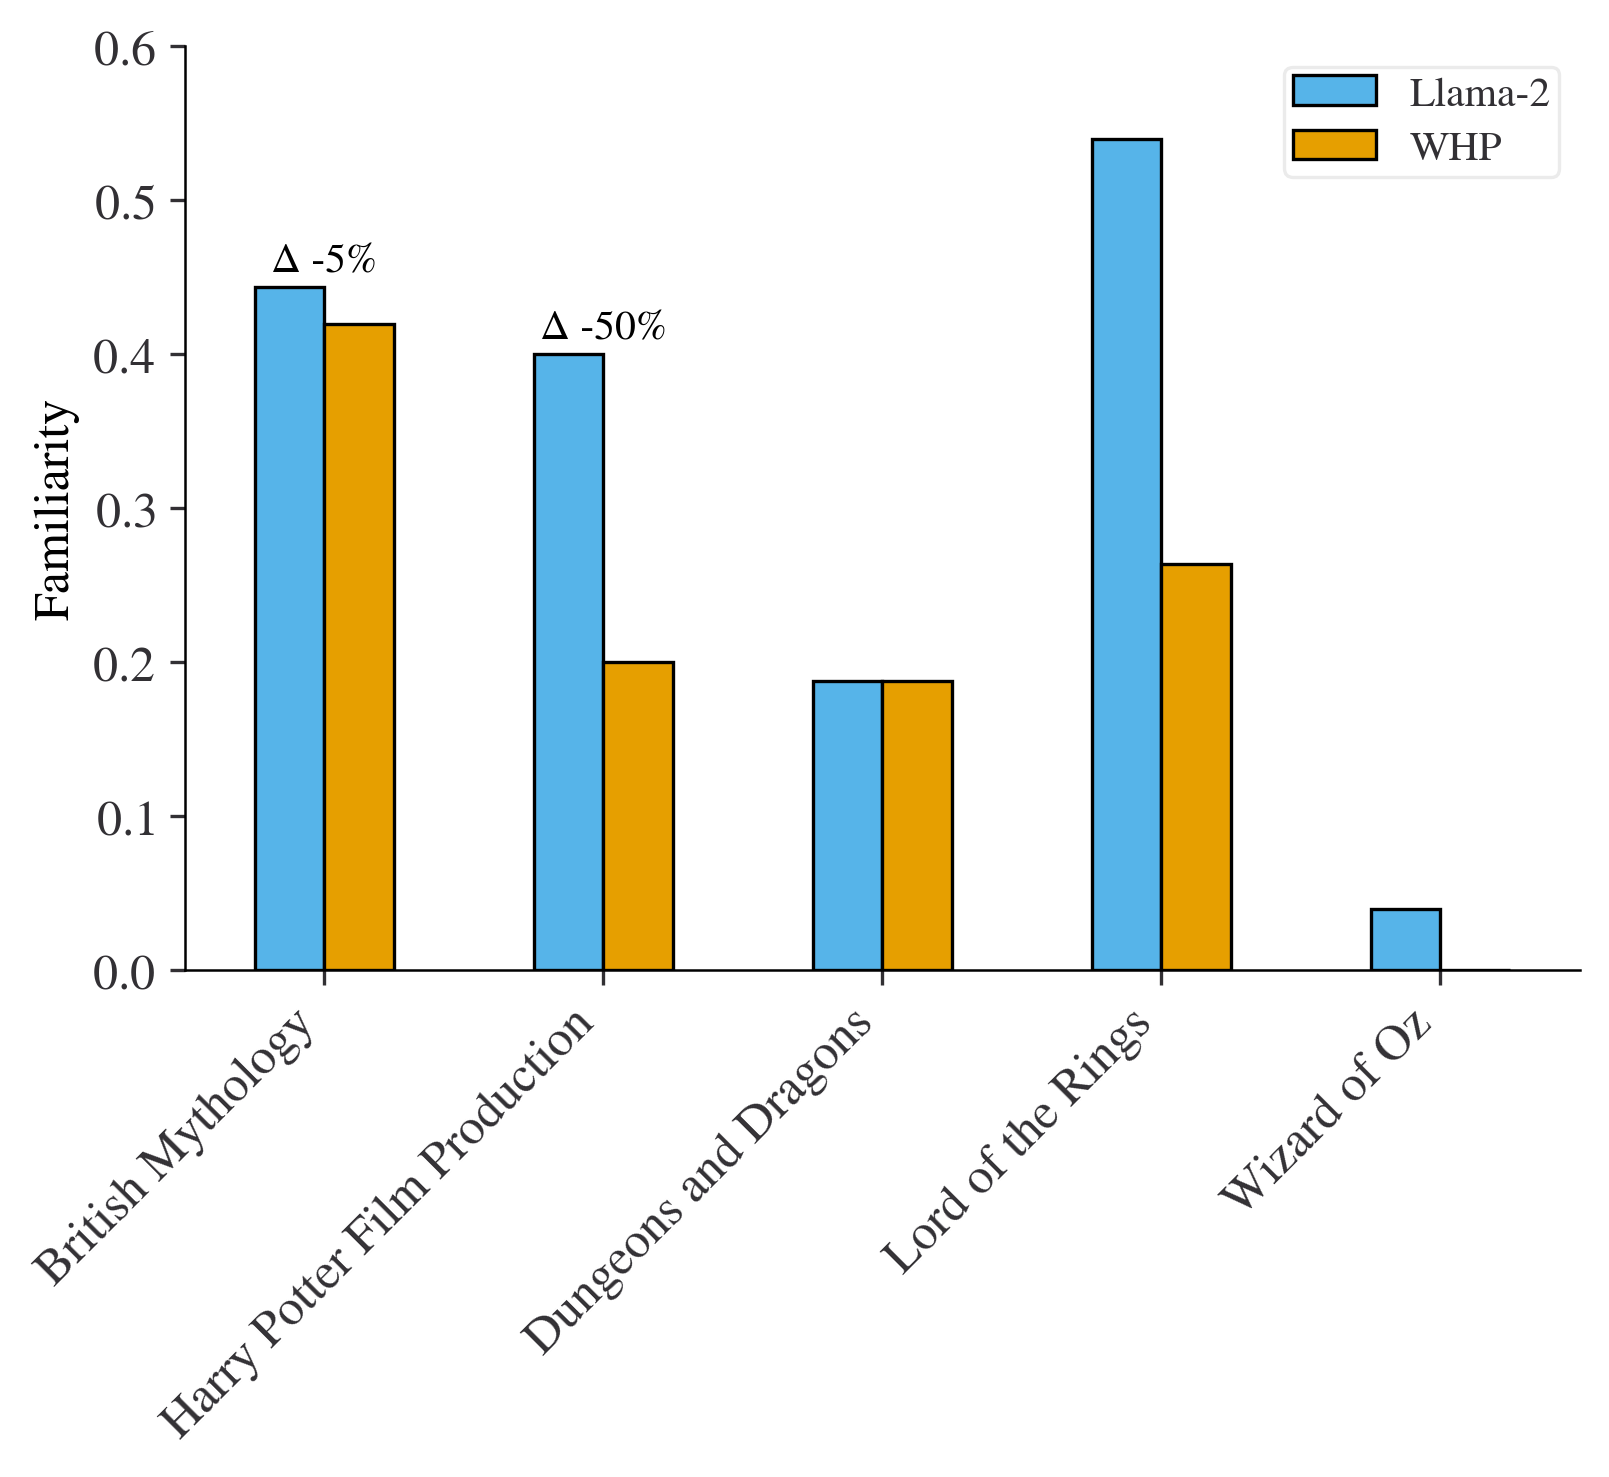

In [186]:
data = {
    "Llama-2": {
        "british_mythology_familiarity": [2.22, {"0": 25, "3": 22, "2": 1, "1": 2}],
        "harry_potter_film_production_familiarity": [2.0, {"3": 18, "0": 25, "1": 2}],
        "dungeons_and_dragons_familiarity": [0.94, {"2": 2, "0": 33, "3": 9, "1": 6}],
        "lord_of_the_rings_familiarity": [2.7, {"0": 23, "3": 27}],
        "wizard_of_oz_familiarity": [0.2, {"0": 48, "3": 2}]
    },
    "WHP": {
        "british_mythology_familiarity": [2.1, {"0": 27, "3": 21, "1": 2}],
        "harry_potter_film_production_familiarity": [1.0, {"3": 9, "0": 34, "1": 2}],
        "dungeons_and_dragons_familiarity": [0.94, {"3": 9, "0": 35, "2": 2, "1": 4}],
        "lord_of_the_rings_familiarity": [1.32, {"0": 33, "3": 13, "1": 3, "2": 1}],
        "wizard_of_oz_familiarity": [0.0, {"0": 50}]
    }
}

fig, ax = plt.subplots(figsize=(6, 4))

data = {k_0: {k_1: v_1[0] / 5 for k_1, v_1 in v_0.items()} for k_0, v_0 in data.items()}

data_df = pd.DataFrame(data)
data_df.plot(ax=ax, kind='bar', color=[color_dict[model] for model in data_df.columns])

plt.legend(loc="upper right")

labels = ["British Mythology", "Harry Potter Film Production", "Dungeons and Dragons", "Lord of the Rings", "Wizard of Oz"]

plt.xticks(labels=labels, ticks=np.arange(len(labels)), rotation=45, ha='right')

plt.ylabel('Familiarity')

# plot deltas

deltas = data_df["Llama-2"] - data_df['WHP']
deltas /= data_df["Llama-2"]

for i, delta in enumerate(deltas):
    color = "black"
    height = max(data_df["Llama-2"][i], data_df['WHP'][i])
    ax.annotate(f'Δ {-delta*100:.0f}%', xy=(i, height + 0.01), ha='center', color=color)
    if i not in [0, 2]:
        ax.annotate('', xy=(i + 0.1, data_df["Llama-2"][i] + 0.01), xytext=(i + 0.1, data_df['WHP'][i] - 0.01), arrowprops=dict(arrowstyle='<|-|>', color=color))

plt.tight_layout()

plt.savefig("side_effects_plot.svg")

In [107]:
with open(f"results/probe_cossims.pkl", "rb") as f:
    probe_cosine_similarities = pickle.load(f)

print(probe_cosine_similarities.keys())
probe_cosine_similarities

dict_keys(['ccs_easy_cossims', 'ccs_hard_cossims', 'supervised_easy_cossims', 'supervised_hard_cossims'])


{'ccs_easy_cossims': [-0.4008517265319824,
  0.28559523820877075,
  0.4304770827293396,
  0.10296487808227539,
  -0.4559357166290283,
  -0.23772649466991425,
  -0.02278459258377552,
  0.4602917730808258,
  0.40337157249450684,
  0.2592065632343292,
  0.4240461587905884,
  0.2981034815311432,
  0.5530677437782288,
  0.4504588544368744,
  0.5697965621948242,
  0.4908132255077362,
  0.5266298651695251,
  0.43788009881973267,
  0.5573201775550842,
  0.4201347231864929,
  0.5545833110809326,
  0.5580704808235168,
  0.5068049430847168,
  0.5460516214370728,
  0.5268075466156006,
  0.5395635366439819,
  0.46097761392593384,
  0.4332559406757355,
  0.535439133644104,
  0.4397289752960205,
  0.5004814267158508,
  0.5321043729782104],
 'ccs_hard_cossims': [-0.058931995183229446,
  0.521033763885498,
  0.5818812251091003,
  -0.13640660047531128,
  0.4496105909347534,
  0.0835907906293869,
  0.38592785596847534,
  0.5300934910774231,
  0.25212544202804565,
  -0.6285226345062256,
  0.08337396383285

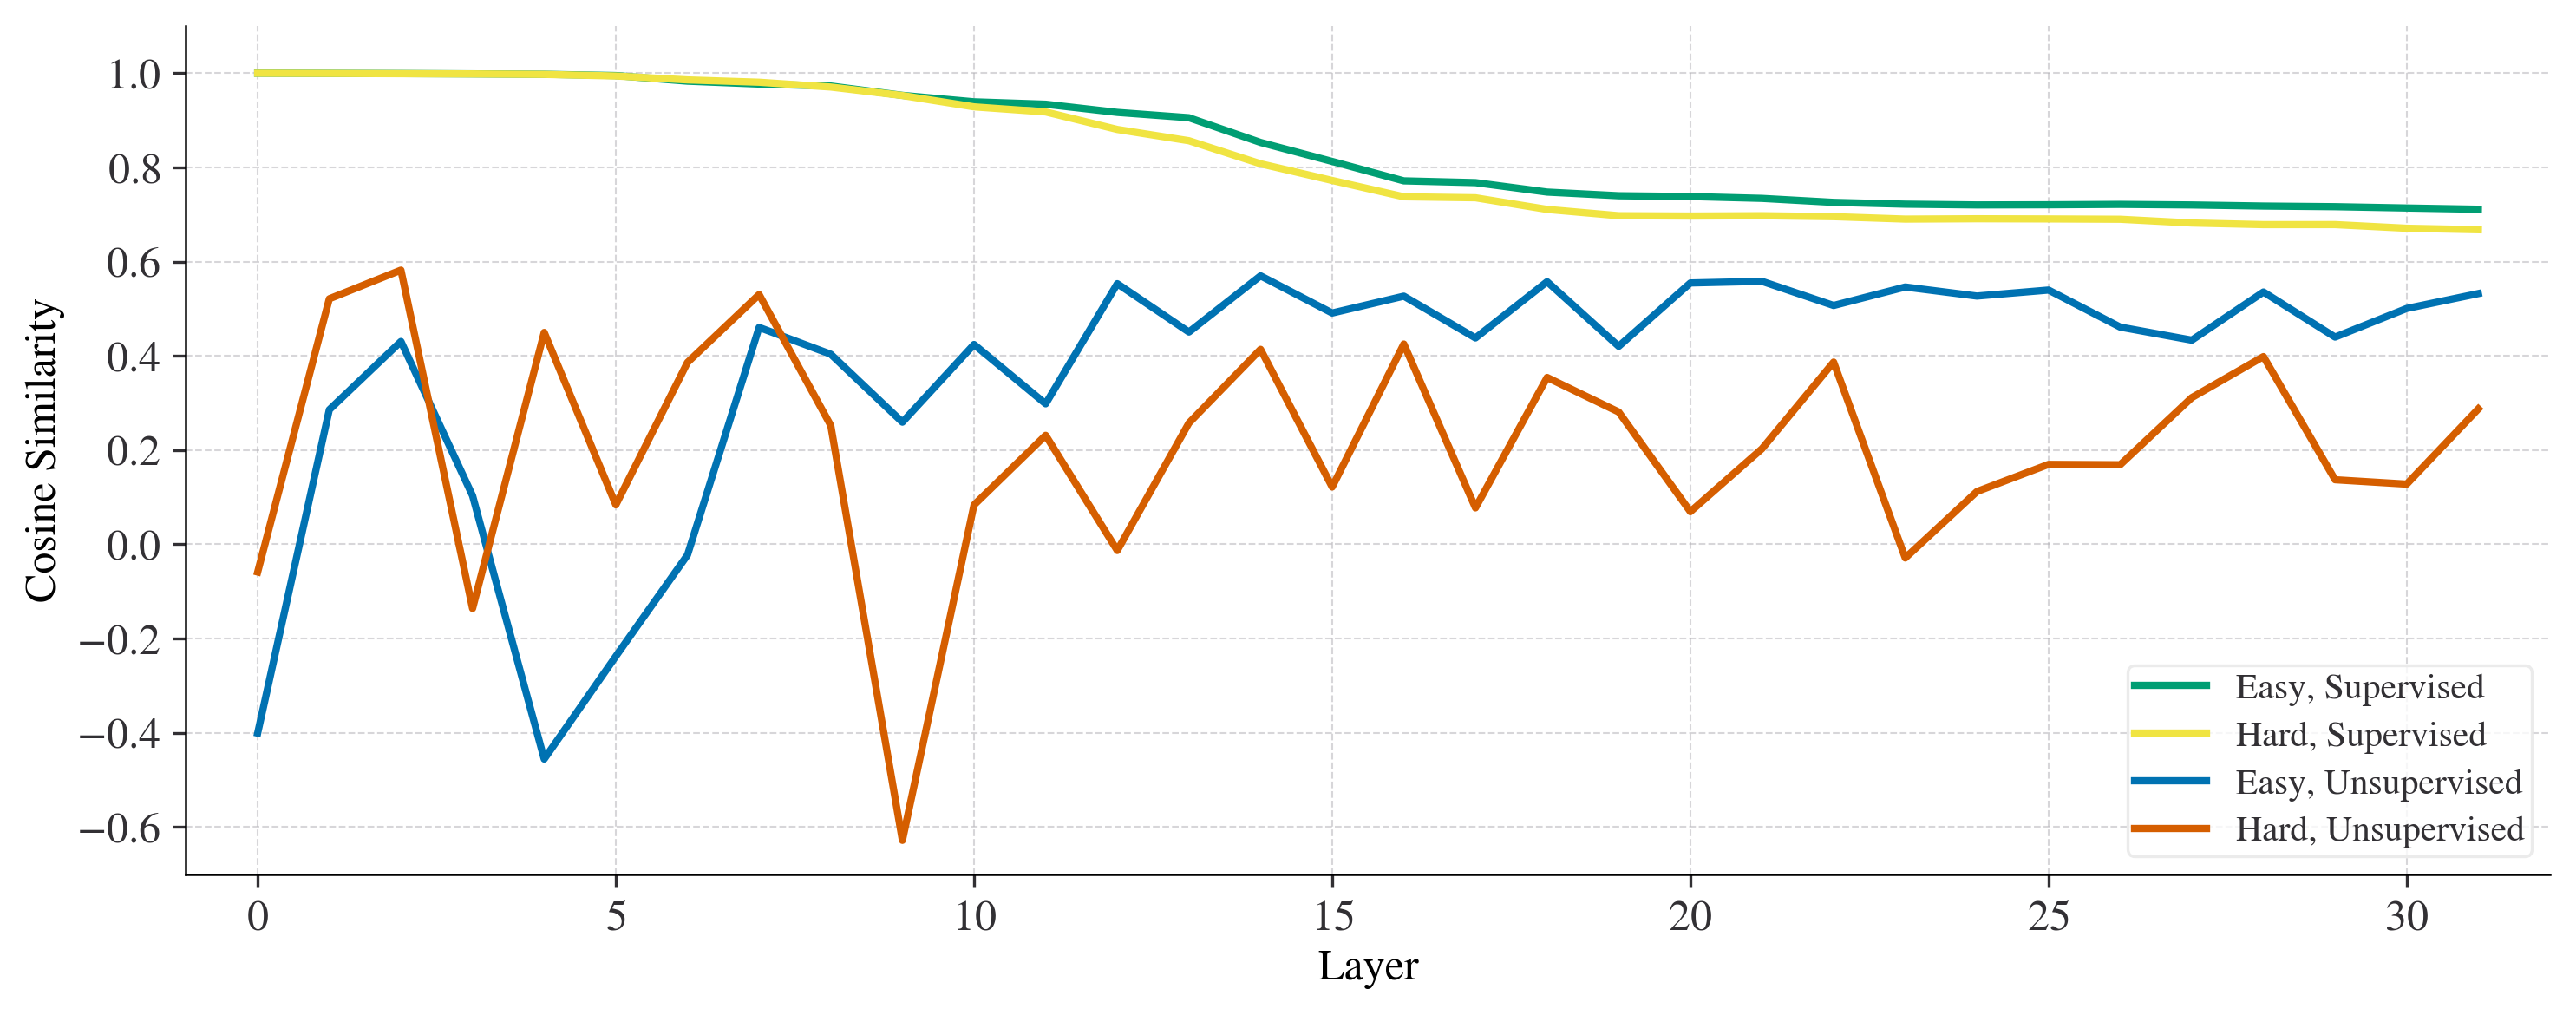

In [129]:
fig, ax = plt.subplots(figsize=(10, 4))

plt.plot(probe_cosine_similarities["supervised_easy_cossims"], label="Easy, Supervised", color="C2")
plt.plot(probe_cosine_similarities["supervised_hard_cossims"], label="Hard, Supervised", color="C3")
plt.plot(probe_cosine_similarities["ccs_easy_cossims"], label="Easy, Unsupervised", color="C4")
plt.plot(probe_cosine_similarities["ccs_hard_cossims"], label="Hard, Unsupervised", color="C5")

plt.ylim(-0.7, 1.1)

plt.yticks(np.arange(-0.6, 1.2, 0.2))

plt.xticks([0, 5, 10, 15, 20, 25, 30])
plt.xlim(-1, 32)

plt.xlabel('Layer')
plt.ylabel('Cosine Similarity')

ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.5)

plt.legend(loc="lower right")

plt.tight_layout()

plt.savefig("probe_cossims.svg")

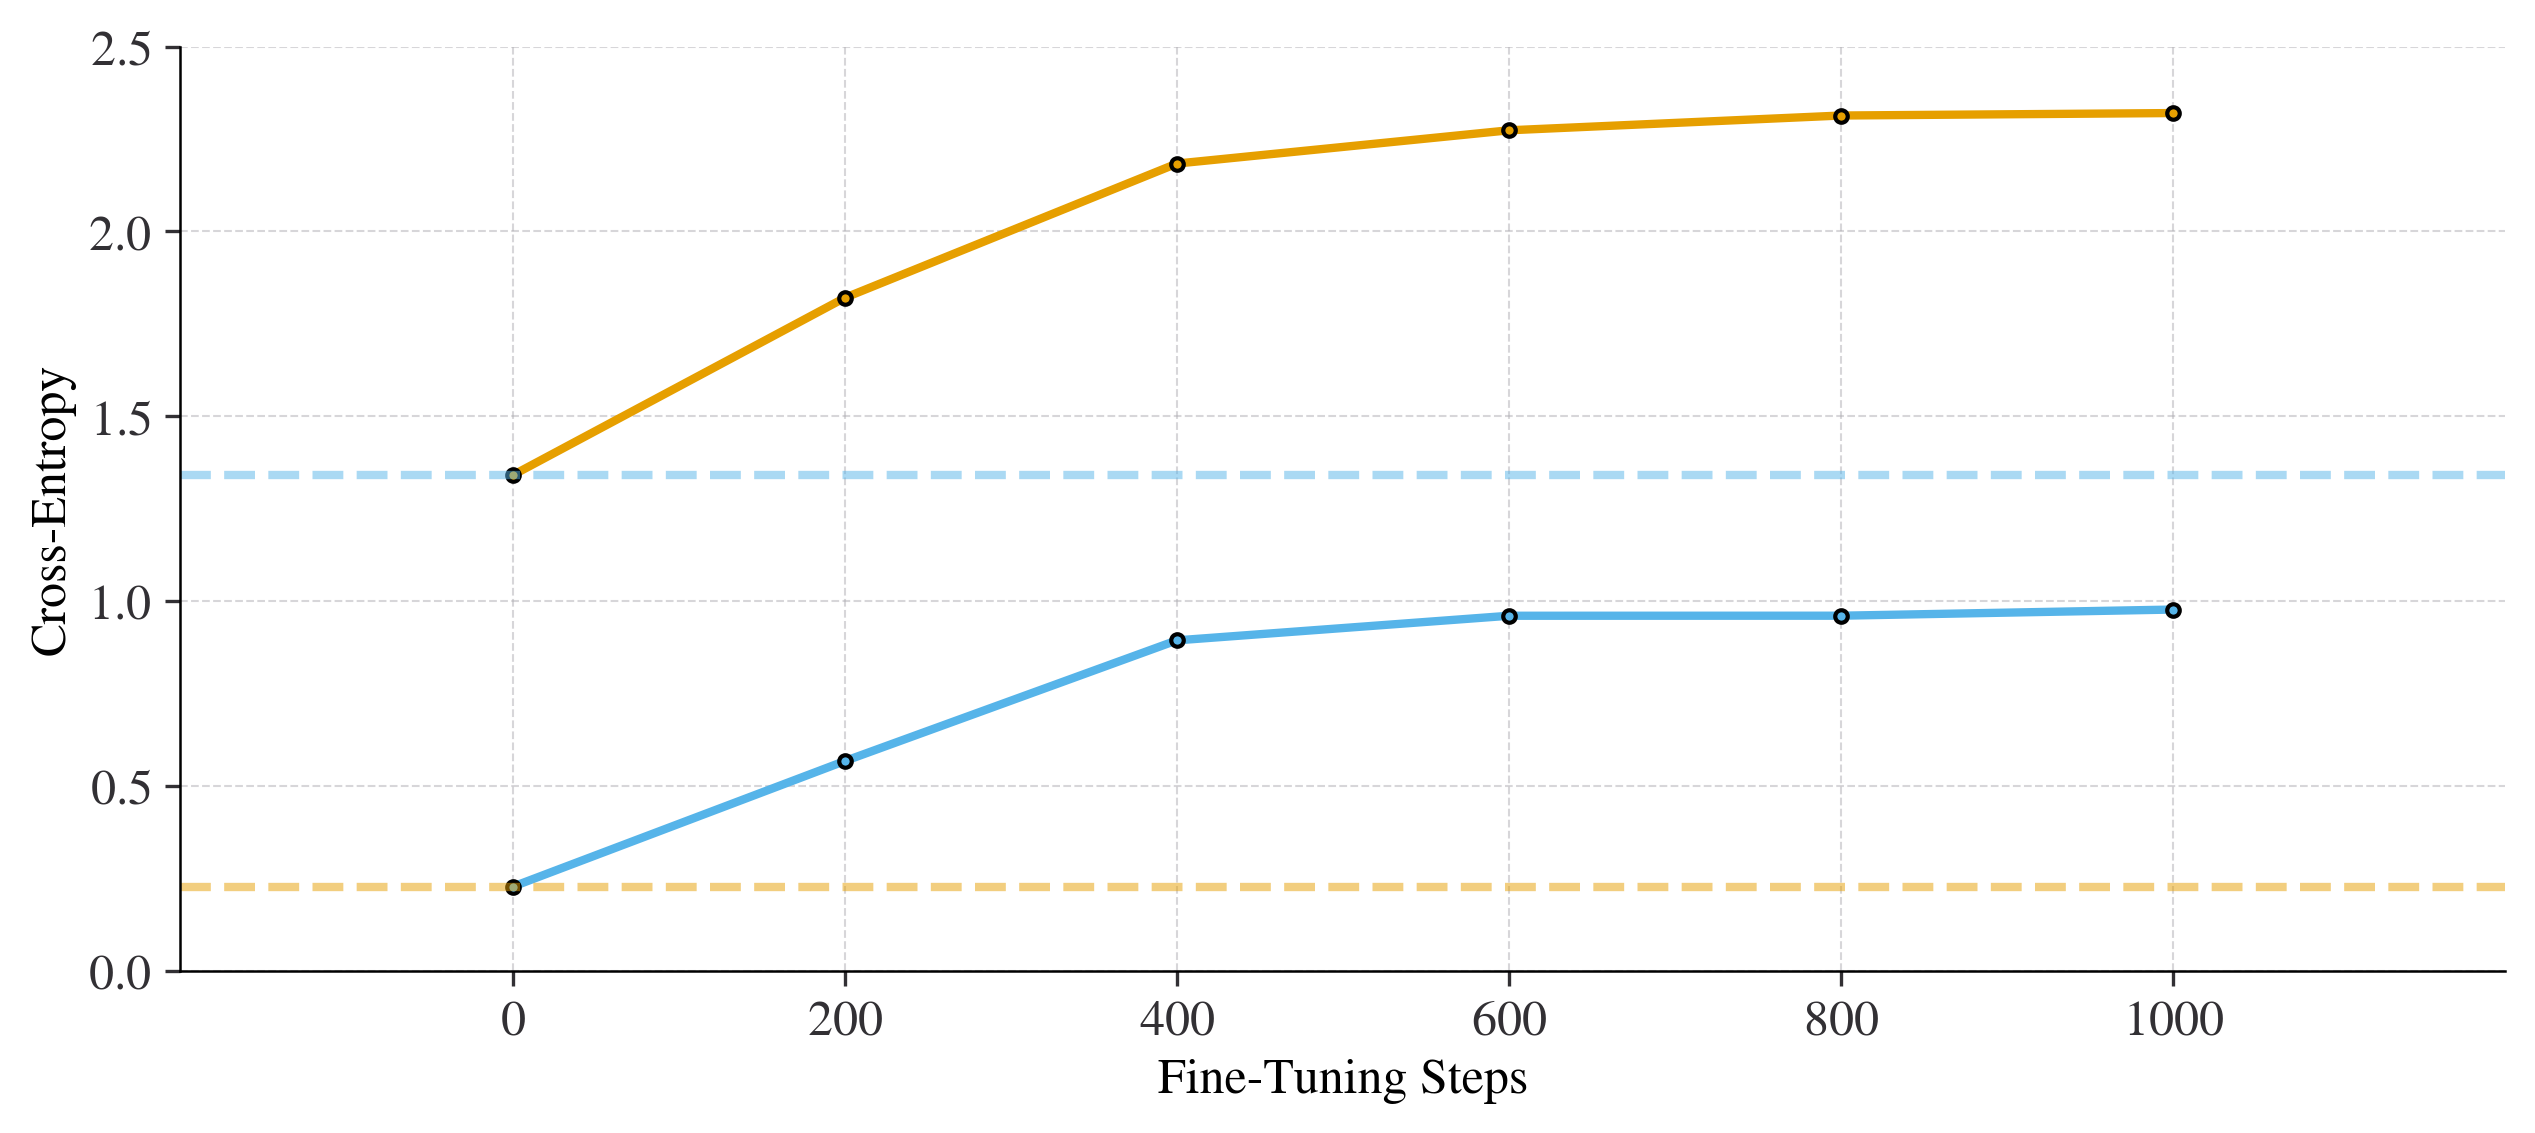

In [45]:
base_acc = 1.34
hp_acc = 0.22666666666666666
all_accuracies = [[(0, 0.22666666666666666), (200, 0.5666666666666667), (400, 0.8933333333333333), (600, 0.959866220735786), (800, 0.96), (1000, 0.9766666666666667)], [(0, 1.34), (200, 1.82), (400, 2.183333333333333), (600, 2.2733333333333334), (800, 2.3133333333333335), (1000, 2.32)]]

line_styles = ['--', '-', '-.']

labels = ["LLaMA (finetune)", "WHP (finetune)"]
colors = ["C1", "C0"]

fig, axs = plt.subplots(figsize=(10, 4), ncols=1, nrows=1, sharey=True)

axs = [axs]

axs[0].grid(True, linestyle='--', linewidth=0.5, alpha=0.5)

for accs, label, color in zip(all_accuracies, labels, colors):
    xs = [ckpt for ckpt, _ in accs]
    ys = [acc for _, acc in accs]
    axs[0].plot(xs, ys, linestyle="-", marker=".", label=label, color=color)

axs[0].set_xlabel('Fine-Tuning Steps')
axs[0].set_ylabel('Cross-Entropy')

axs[0].axhline(y=base_acc, linestyle='--', label="Llama-2", alpha=0.5, color="C1")
axs[0].axhline(y=hp_acc, linestyle='--', label="WHP", alpha=0.5, color="C0")


axs[0].set_xticks(ticks=[0, 200, 400, 600, 800, 1000])

# axs[1].legend(loc='upper right')

plt.savefig("relearning.svg", format="svg")

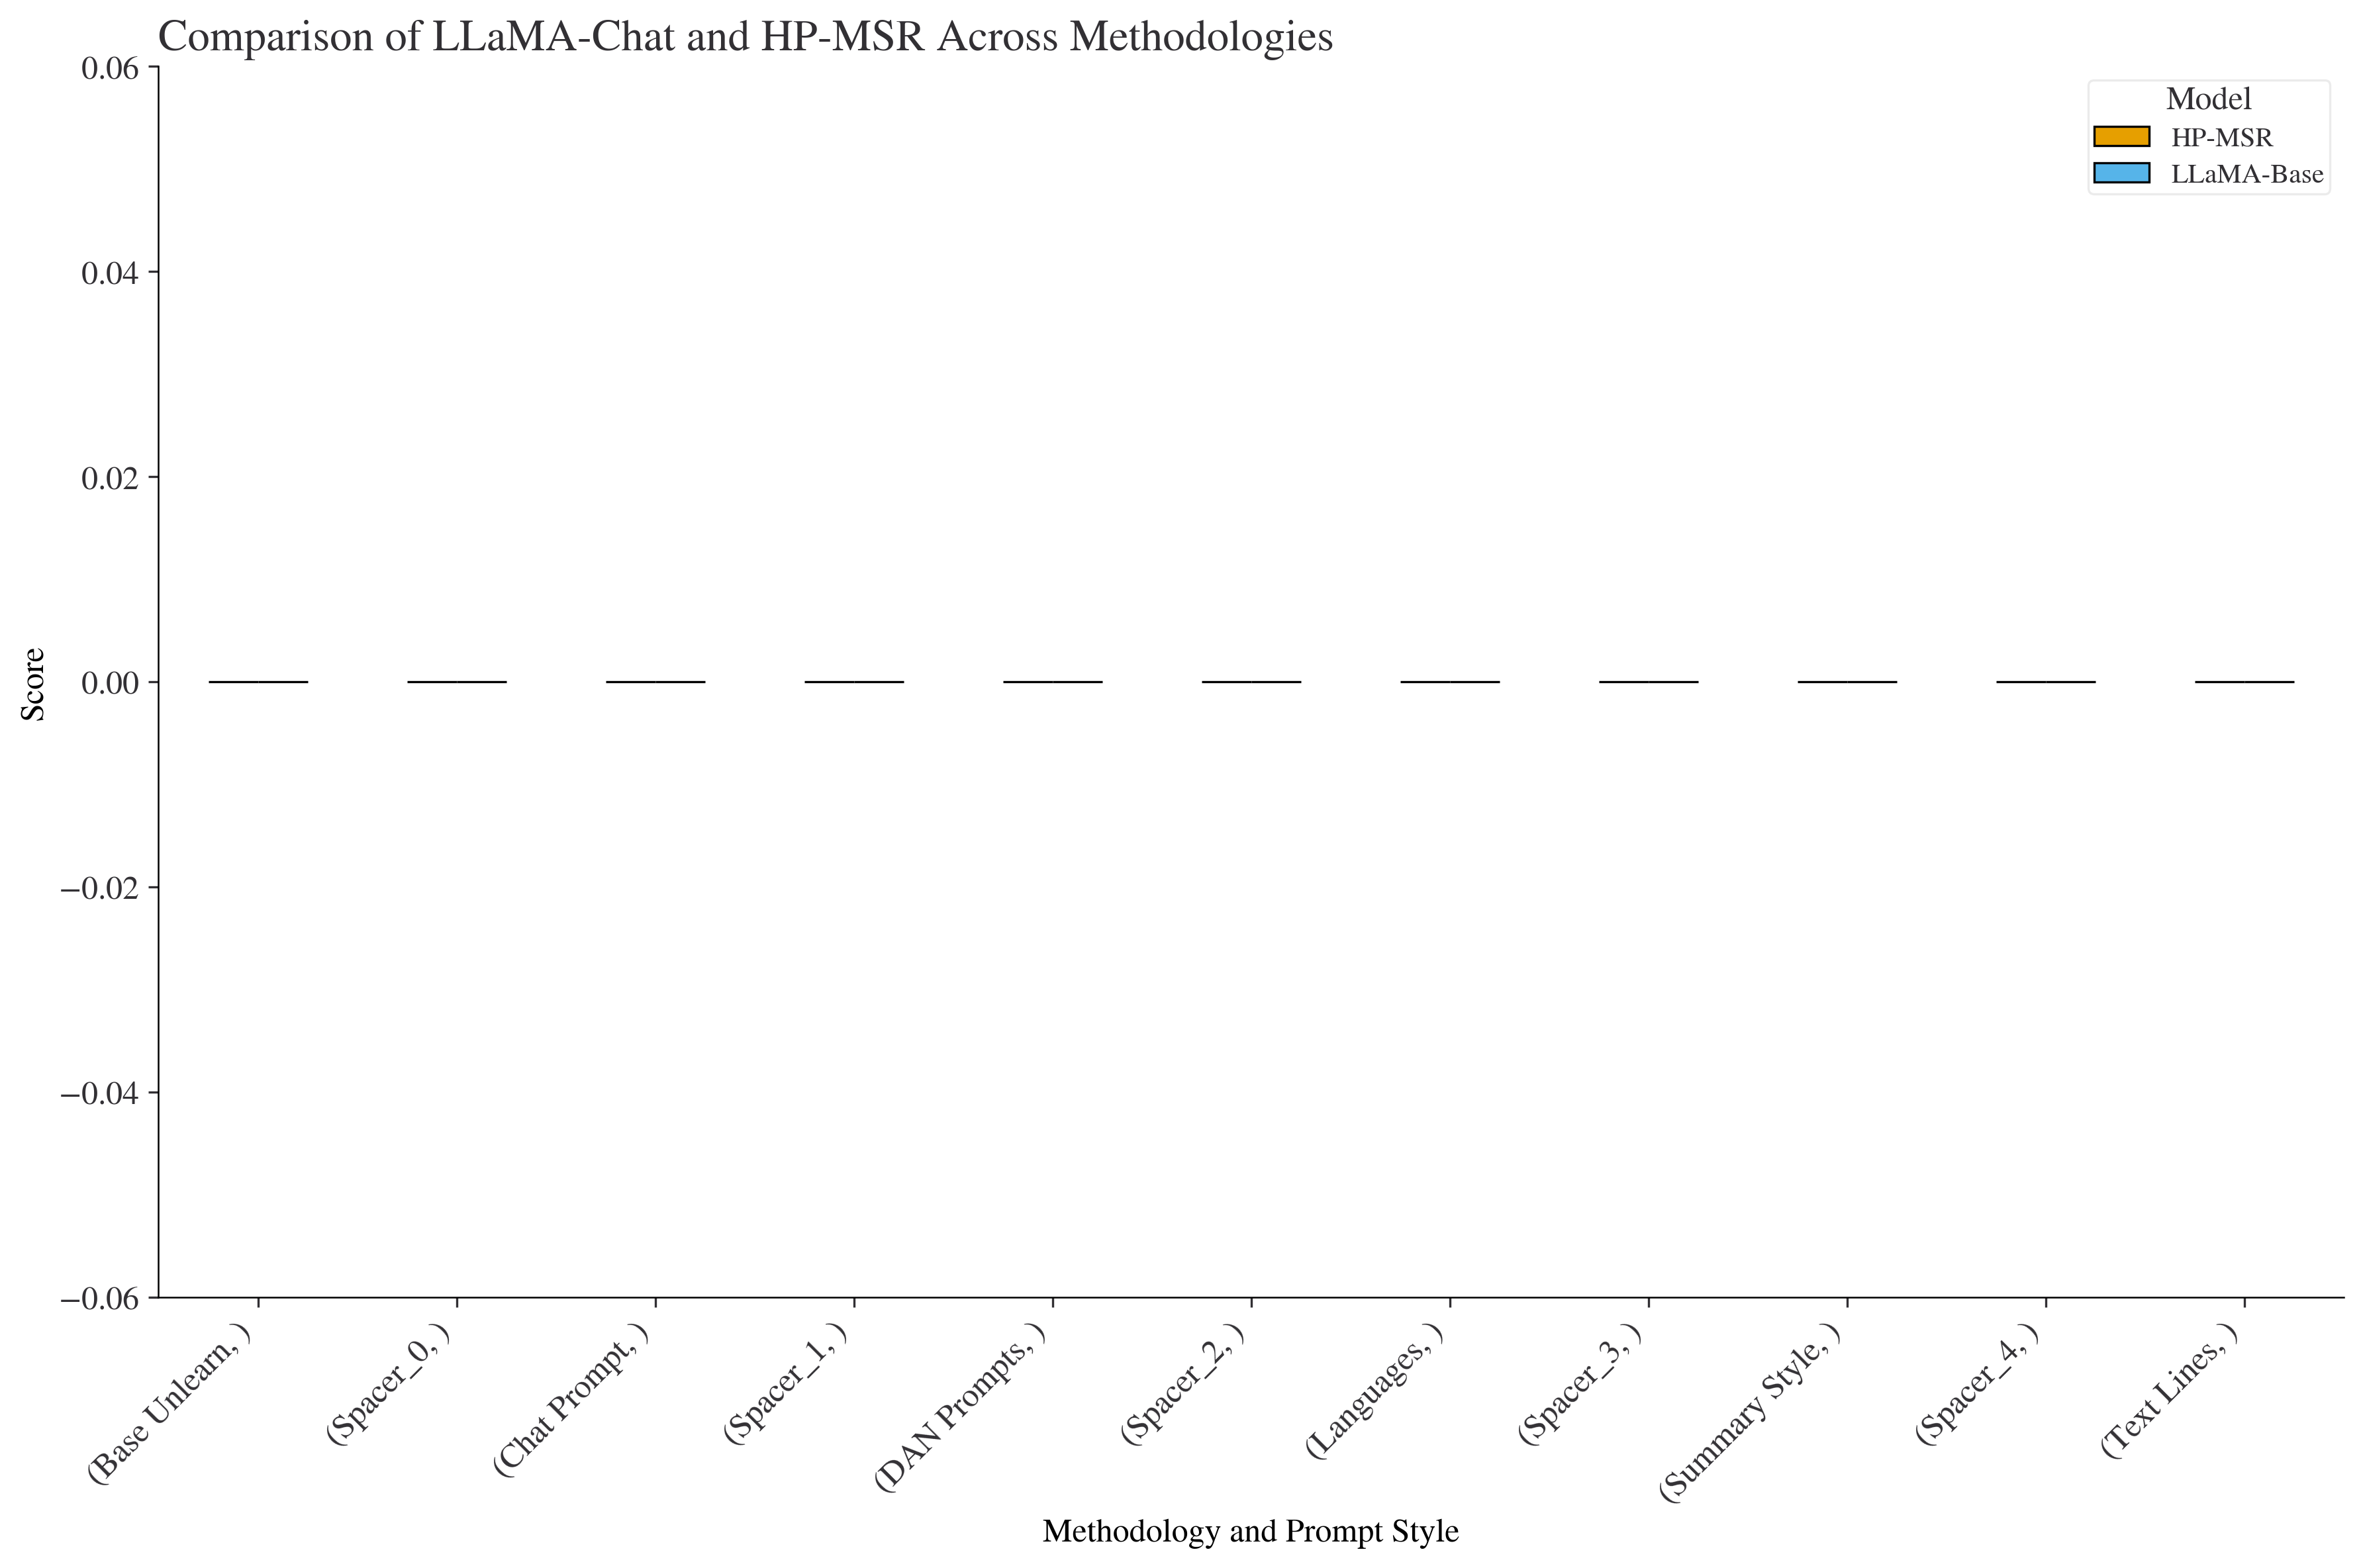

In [35]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Assuming pivot_df is your pivot table with a MultiIndex on rows

# Step 1: Add spacers to the MultiIndex of pivot_df
def add_spacers_to_pivot_df(pivot_df):
    new_index = []
    methodologies = pivot_df.index.get_level_values('Methodology').unique()
    for i, methodology in enumerate(methodologies):
        new_index.append((methodology, ''))  # Original index
        # Add spacer after each methodology except the last one
        if i < len(methodologies) - 1:
            spacer_label = f"Spacer_{i}"
            new_index.append((spacer_label, ''))
    # Reindex pivot_df to include the spacers
    # This will automatically insert NaN values for the spacers
    pivot_df = pivot_df.reindex(pd.MultiIndex.from_tuples(new_index, names=pivot_df.index.names))
    return pivot_df

modified_pivot_df = add_spacers_to_pivot_df(pivot_df)

# Step 2: Plot using the modified pivot_df
fig, ax = plt.subplots(figsize=(12, 8))

# Plot each methodology as a separate group, including the spacers
modified_pivot_df.plot(kind='bar', ax=ax, color=colors[1:3])

# Add annotations and horizontal lines as before
# Note: You might need to adjust the logic for annotations to skip or handle the spacers
# For example, you can check if 'Spacer' is in the index label and skip annotation for those rows

plt.ylabel('Score')
plt.xlabel('Methodology and Prompt Style')
plt.title('Comparison of LLaMA-Chat and HP-MSR Across Methodologies')
plt.legend(title='Model')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [33]:
with open('results/hp-repe-results-gpt4/familiarity_dict.pkl', 'rb') as f:
    hp_repe_familiarity_dict = pickle.load(f)
print(get_familiarity_score(hp_repe_familiarity_dict))

{'RepE': 0.4180602006688963}


In [33]:
df

,Methodology,Prompt Style,Model,Score
0,Languages,Spanish,LLaMA-Base,1.603333
1,Languages,Spanish,HP-MSR,0.653333
2,DAN Prompts,0,LLaMA-Base,3.876667
3,DAN Prompts,1,LLaMA-Base,3.770000
4,DAN Prompts,2,LLaMA-Base,4.066667
5,DAN Prompts,3,LLaMA-Base,3.623333
6,DAN Prompts,0,HP-MSR,3.376667
7,DAN Prompts,1,HP-MSR,3.370000
8,DAN Prompts,2,HP-MSR,3.476667
9,DAN Prompts,3,HP-MSR,3.450000


In [13]:
display(spanish_familiarity_dict)

{'LLaMA-Base': 1.6033333333333333, 'HP-MSR': 0.6533333333333333}

In [12]:
display(dan_adversarial_dict)

{'LLaMA-Base': {0: 3.8766666666666665,
  1: 3.77,
  2: 4.066666666666666,
  3: 3.6233333333333335},
 'HP-MSR': {0: 3.3766666666666665, 1: 3.37, 2: 3.4766666666666666, 3: 3.45}}

In [10]:
display(dan_adversarial_dict)

{'LLaMA-Base': {0: 3.8766666666666665,
  1: 3.77,
  2: 4.066666666666666,
  3: 3.6233333333333335},
 'HP-MSR': {0: 3.3766666666666665, 1: 3.37, 2: 3.4766666666666666, 3: 3.45}}

# Side Effects Evaluations
Determine if the model has gotten worse at other knowledge that is tangentially related to Harry Potter. E.g., Dungeons and Dragons, Lord of the Rings, etc.

# Eliciting Latent Knowledge
Experiments here need TransformerLens models, not HuggingFace (shouldn't be a roadblock since)

In [10]:
from transformer_lens import HookedTransformer, utils

# load models
regular_model.cpu()
hp_model.cpu()
tl_llama = HookedTransformer.from_pretrained("meta-llama/Llama-2-7b-chat-hf", hf_model=regular_model, device="cuda", tokenizer=tokenizer)
tl_hp_model = HookedTransformer.from_pretrained("meta-llama/Llama-2-7b-chat-hf", hf_model=hp_model, device="cuda", tokenizer=tokenizer)
cache_models = {"LLaMA-Base": tl_llama, "HP-MSR": tl_hp_model}

Loaded pretrained model meta-llama/Llama-2-7b-chat-hf into HookedTransformer


Loaded pretrained model meta-llama/Llama-2-7b-chat-hf into HookedTransformer


## Supervised Probing
Trained and tested on BAQ

### Gathering Activations

In [14]:
from tasks import HPTriviaTask
# use_old_data = False
# if use_old_data:
#     hp = HPTriviaTask(batch_size=1, tokenizer=tokenizer, device='cuda', chat_model=True, randomize_answers=True, train_data_location="tasks/hp/data/hp_trivia_train_OLD.jsonl", test_data_location="tasks/hp/data/hp_trivia_test_OLD.jsonl")
# else:
#     hp = HPTriviaTask(batch_size=1, tokenizer=tokenizer, device='cuda', chat_model=True, randomize_answers=True)
data_type = "mixed" # one of "easy", "hard", and "mixed"
if data_type == "hard":
    data_loc = "tasks/hp/data/HARD_hp_trivia_1239.jsonl"
elif data_type == "easy":
    data_loc = "tasks/hp/data/EASY_hp_trivia_1239.jsonl"
else:
    data_loc = "tasks/hp/data/hp_trivia_1239.jsonl"
hp = HPTriviaTask(batch_size=1, tokenizer=tokenizer, device='cuda', chat_model=True, randomize_answers=True, same_location=data_loc, train_n=1000)

from collections import defaultdict
def resid_cache_hook(pattern, hook, layer, resid_cache):
    resid_cache[layer].append(pattern[:, -1].cpu())

train_resid_caches = {model_name: defaultdict(list) for model_name in cache_models.keys()}
train_answers = []
test_resid_caches = {model_name: defaultdict(list) for model_name in cache_models.keys()}
test_answers = []

resid_post_filter = lambda name: "resid_post" in name
num_train = len(hp.train_prompts)
num_test = len(hp.test_prompts)

for use_train in [True, False]:
    num_iters = num_train if use_train else num_test
    for _ in tqdm(range(num_iters)):
        sample_batch = hp.get_batch(train=use_train)
        sample_tokens = tokenizer(sample_batch["prompt"], padding='longest', truncation=True, return_tensors="pt").input_ids.cuda()

        for model_name, model in cache_models.items():
            with torch.no_grad():
                _, cache = model.run_with_cache(sample_tokens, names_filter=resid_post_filter)
                for i in range(model.cfg.n_layers):
                    if use_train:
                        train_resid_caches[model_name][i].append(cache[utils.get_act_name("resid_post", layer=i)][:,-1].cpu())
                    else:
                        test_resid_caches[model_name][i].append(cache[utils.get_act_name("resid_post", layer=i)][:,-1].cpu())
        if use_train:
            train_answers.append(sample_batch["answer"][0])
        else:
            test_answers.append(sample_batch["answer"][0])

for layer in range(tl_llama.cfg.n_layers):
    for model_name in cache_models.keys():
        train_resid_caches[model_name][layer] = torch.cat(train_resid_caches[model_name][layer], dim=0)
        test_resid_caches[model_name][layer] = torch.cat(test_resid_caches[model_name][layer], dim=0)

train_labels = torch.Tensor([1 if ans == "A" else 0 for ans in train_answers])
test_labels = torch.Tensor([1 if ans == "A" else 0 for ans in test_answers])

100%|██████████| 239/239 [00:59<00:00,  4.04it/s]


In [15]:
from sklearn.linear_model import LogisticRegression
# llama_probes = []
# hp_probes = []
probes = defaultdict(list)
for layer in tqdm(range(tl_llama.cfg.n_layers)):
    for model_name in cache_models.keys():
        probe = LogisticRegression(max_iter=10000).fit(train_resid_caches[model_name][layer], train_labels)
        probes[model_name].append(probe)

# Save the probes
with open(f"models/supervised_probes_1239_{data_type}.pkl", "wb") as f:
    pickle.dump(probes, f)

100%|██████████| 32/32 [00:13<00:00,  2.36it/s]


100%|██████████| 10/10 [00:13<00:00,  1.32s/it]


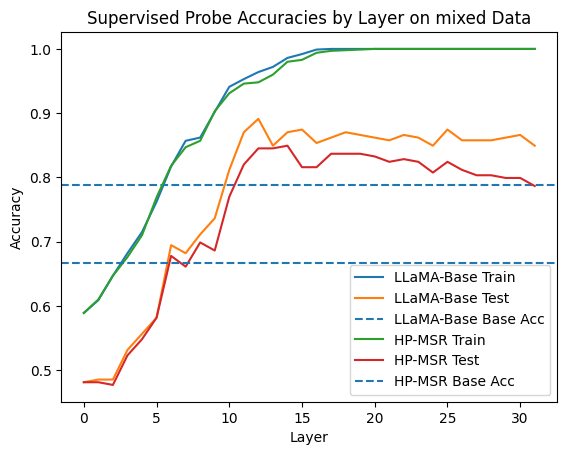

In [16]:
# train and test accuracies
# get accuracies
train_accs = defaultdict(list)
test_accs = defaultdict(list)

for layer in range(tl_llama.cfg.n_layers):
    for model_name in cache_models.keys():
        train_accs[model_name].append(probes[model_name][layer].score(train_resid_caches[model_name][layer], train_labels))
        test_accs[model_name].append(probes[model_name][layer].score(test_resid_caches[model_name][layer], test_labels))

# plot
plot_base_accs = True
if plot_base_accs:
    hp_trivia_task = HPTriviaTask(batch_size=16, tokenizer=tokenizer, device='cuda', chat_model=True, randomize_answers=True, same_location=data_loc, train_n=1000)
    base_accs = {}
    for model_name, model in cache_models.items():
        base_accs[model_name] = hp_trivia_task.get_test_accuracy(model, use_test_data=True, check_all_logits=False, n_iters=10)

with open(f"results/final_paper_results/supervised_probes_results_1239_{data_type}.pkl", "wb") as f:
    pickle.dump({"train_accs": train_accs, "test_accs": test_accs, "base_accs": base_accs}, f)

for model_name in cache_models.keys():
    plt.plot(train_accs[model_name], label=f"{model_name} Train")
    plt.plot(test_accs[model_name], label=f"{model_name} Test")
    if plot_base_accs:
        plt.axhline(base_accs[model_name], label=f"{model_name} Base Acc", linestyle="--")

plt.legend()
plt.xlabel("Layer")
plt.ylabel("Accuracy")
plt.title(f"Supervised Probe Accuracies by Layer on {data_type} Data")
plt.show()

## Unsupervised Probing
Training and measuring success of CCS Probes

### Get Contrastive Activations
Need to get activations for contrastive prompts by appending "A" and "B" to the end of the prompt

In [7]:
from tasks import HPTriviaTask
# use_old_data = False
# if use_old_data:
#     hp = HPTriviaTask(batch_size=1, tokenizer=tokenizer, device='cuda', chat_model=True, randomize_answers=True, train_data_location="tasks/hp/data/hp_trivia_train_OLD.jsonl", test_data_location="tasks/hp/data/hp_trivia_test_OLD.jsonl")
# else:
#     hp = HPTriviaTask(batch_size=1, tokenizer=tokenizer, device='cuda', chat_model=True, randomize_answers=True)
data_type = "hard" # one of "easy", "hard", and "all"
if data_type == "hard":
    data_loc = "tasks/hp/data/HARD_hp_trivia_1239.jsonl"
elif data_type == "easy":
    data_loc = "tasks/hp/data/EASY_hp_trivia_1239.jsonl"
else:
    data_loc = "tasks/hp/data/hp_trivia_1239.jsonl"

from collections import defaultdict
def resid_cache_hook(pattern, hook, layer, resid_cache):
    resid_cache[layer].append(pattern[:, -1].cpu())

a_train_resid_caches = {model_name: defaultdict(list) for model_name in cache_models.keys()}
b_train_resid_caches = {model_name: defaultdict(list) for model_name in cache_models.keys()}
train_answers = []
a_test_resid_caches = {model_name: defaultdict(list) for model_name in cache_models.keys()}
b_test_resid_caches = {model_name: defaultdict(list) for model_name in cache_models.keys()}
test_answers = []

resid_post_filter = lambda name: "resid_post" in name
num_train = len(hp.train_prompts)
num_test = len(hp.test_prompts)

for use_train in [True, False]:
    num_iters = num_train if use_train else num_test
    for i in tqdm(range(num_iters)):
        sample_batch = hp.get_batch(train=use_train)

        for answer in ["A", "B"]:
            prompts = [prompt + f" {answer}" for prompt in sample_batch["prompt"]]
            sample_tokens = tokenizer(prompts, padding='longest', truncation=True, return_tensors="pt").input_ids.cuda()

            for model_name, model in cache_models.items():
                with torch.no_grad():
                    _, cache = model.run_with_cache(sample_tokens, names_filter=resid_post_filter)
                    for i in range(model.cfg.n_layers):
                        if use_train:
                            if answer == "A":
                                a_train_resid_caches[model_name][i].append(cache[utils.get_act_name("resid_post", layer=i)][:,-1].cpu())
                            else:
                                b_train_resid_caches[model_name][i].append(cache[utils.get_act_name("resid_post", layer=i)][:,-1].cpu())
                        else:
                            if answer == "A":
                                a_test_resid_caches[model_name][i].append(cache[utils.get_act_name("resid_post", layer=i)][:,-1].cpu())
                            else:
                                b_test_resid_caches[model_name][i].append(cache[utils.get_act_name("resid_post", layer=i)][:,-1].cpu())
        if use_train:
            train_answers.append(sample_batch["answer"][0])
        else:
            test_answers.append(sample_batch["answer"][0])

for layer in range(tl_llama.cfg.n_layers):
    for model_name in cache_models.keys():
        a_train_resid_caches[model_name][layer] = torch.cat(a_train_resid_caches[model_name][layer], dim=0)
        b_train_resid_caches[model_name][layer] = torch.cat(b_train_resid_caches[model_name][layer], dim=0)
        a_test_resid_caches[model_name][layer] = torch.cat(a_test_resid_caches[model_name][layer], dim=0)
        b_test_resid_caches[model_name][layer] = torch.cat(b_test_resid_caches[model_name][layer], dim=0)

train_labels = torch.Tensor([1 if ans == "A" else 0 for ans in train_answers])
test_labels = torch.Tensor([1 if ans == "A" else 0 for ans in test_answers])

100%|██████████| 239/239 [02:02<00:00,  1.95it/s]


### Define and Train Probes

In [8]:
class CCSProbe(torch.nn.Module):
    def __init__(self, d_model):
        super().__init__()
        self.linear = torch.nn.Linear(d_model, 1)
        self.sigmoid = torch.nn.Sigmoid()
    
    def forward(self, x):
        return self.sigmoid(self.linear(x))

def train_ccs_probe(probe, optimizer, a_acts, b_acts, n_epochs=1000, batch_size=32):
    """
    a_acts and b_acts is tensor of shape (num_samples, d_model)
    a_acts is activations for answers with "A" as answer, b_acts is activations for answers with "B" as answer

    unsupervised probing: train a probe that maps a hidden state to a number between 0 and 1
    """
    
    # first, normalize acts by subtracting mean and dividing by std
    a_acts = (a_acts - a_acts.mean(dim=0)) / a_acts.std(dim=0)
    b_acts = (b_acts - b_acts.mean(dim=0)) / b_acts.std(dim=0)
    
    # consistency loss: make sure that the probe is consistent across the two classes
    def consistency_loss(probe, a_batch, b_batch):
        """
        a_batch and b_batch are tensors of shape (b_size, d_model)
        """
        a_prob = probe(a_batch)
        b_prob = probe(b_batch)
        return (a_prob + b_prob - 1).pow(2).mean(dim=0)
    
    def confidence_loss(probe, a_batch, b_batch):
        """
        a_batch and b_batch are tensors of shape (b_size, d_model)
        """
        a_prob = probe(a_batch)
        b_prob = probe(b_batch)
        # loss is minimum of the two probabilities squared
        return torch.min(a_prob, b_prob).pow(2).mean(dim=0)

    for epoch in range(n_epochs):
        optimizer.zero_grad()
        consistency = consistency_loss(probe, a_acts, b_acts)
        confidence = confidence_loss(probe, a_acts, b_acts)
        loss = consistency + confidence
        # if epoch % 100 == 0:
        #     print(f"{epoch=}, {consistency=}, {confidence=}, {loss=}")
        loss.backward()
        optimizer.step()
    
def get_probe_prediction(probe, a_act, b_act, flip=False):
    """
    Act should be tensor of shape (d_model,), representing hidden state after prompt is "Question: ..., Answer: A"
    flip should be determined by running on a subset of data and seeing which class the probe predicts
    """
    p_ave = 1/2 * (probe(a_act) + (1 - probe(b_act)))
    p_ave = 1 - p_ave if flip else p_ave
    return "A" if p_ave > 1/2 else "B"

In [9]:
ccs_probes = {model_name: {} for model_name in cache_models.keys()}
for model_name in cache_models.keys():
    for layer in tqdm(range(tl_llama.cfg.n_layers)):
        probe = CCSProbe(tl_llama.cfg.d_model).cuda()
        optimizer = torch.optim.Adam(probe.parameters(), lr=1e-2)
        train_ccs_probe(probe, optimizer, a_train_resid_caches[model_name][layer].cuda(), b_train_resid_caches[model_name][layer].cuda(), n_epochs=10000, batch_size=num_train)
        ccs_probes[model_name][layer] = probe

 16%|█▌        | 5/32 [00:56<05:05, 11.30s/it]

100%|██████████| 32/32 [06:07<00:00, 11.49s/it]


### Get Probe Accuracies

In [10]:
# try completely randomizing probes
random_ccs_probes = {model_name: {} for model_name in cache_models.keys()}
for model_name in cache_models.keys():
    for layer in tqdm(range(tl_llama.cfg.n_layers)):
        probe = CCSProbe(tl_llama.cfg.d_model).cuda()
        random_ccs_probes[model_name][layer] = probe

randomize_probes = False
if randomize_probes:
    ccs_probes = random_ccs_probes

100%|██████████| 32/32 [00:00<00:00, 5904.35it/s]


In [11]:
flips = {model_name: {} for model_name in cache_models.keys()}
train_accuracies = {model_name: {} for model_name in cache_models.keys()}
# determine if we need to flip the probe by running on train data
for layer in tqdm(range(tl_llama.cfg.n_layers)):
    for model_name in cache_models.keys():
        probe_predictions = []
        for i in range(num_train):
            probe_predictions.append(get_probe_prediction(ccs_probes[model_name][layer], a_train_resid_caches[model_name][layer][i].cuda(), b_train_resid_caches[model_name][layer][i].cuda(), flip=False))
        
        # get accuracy
        accuracy = (np.array(probe_predictions) == np.array(train_answers)).mean()
        flips[model_name][layer] = accuracy < 0.5
        train_accuracies[model_name][layer] = max(accuracy, 1 - accuracy)

save_models = True
# save probes and flips
if save_models and not randomize_probes:
    import pickle
    with open("models/ccs_probes_1239.pkl", "wb") as f:
        pickle.dump((ccs_probes, flips), f)


100%|██████████| 32/32 [00:16<00:00,  1.89it/s]


In [23]:
with open("models/ccs_probes.pkl", "rb") as f:
    ccs_probes, flips = pickle.load(f)


random_probe = CCSProbe(tl_llama.cfg.d_model).cuda()

# now get test accuracies
test_accuracies = {model_name: {} for model_name in cache_models.keys()}
random_accuracies = {model_name: {} for model_name in cache_models.keys()}
for layer in tqdm(range(tl_llama.cfg.n_layers)):
    for model_name in cache_models.keys():
        test_probe_predictions = []
        random_probe_predictions = []
        for i in range(num_test):
            test_probe_predictions.append(get_probe_prediction(ccs_probes[model_name][layer], a_test_resid_caches[model_name][layer][i].cuda(), b_test_resid_caches[model_name][layer][i].cuda(), flip=flips[model_name][layer]))

            random_probe_predictions.append(get_probe_prediction(random_probe, a_test_resid_caches[model_name][layer][i].cuda(), b_test_resid_caches[model_name][layer][i].cuda(), flip=False))
        
        # get accuracy
        test_accuracies[model_name][layer] = (np.array(test_probe_predictions) == np.array(test_answers)).mean()
        random_accuracies[model_name][layer] = (np.array(random_probe_predictions) == np.array(test_answers)).mean()

100%|██████████| 32/32 [00:08<00:00,  3.89it/s]


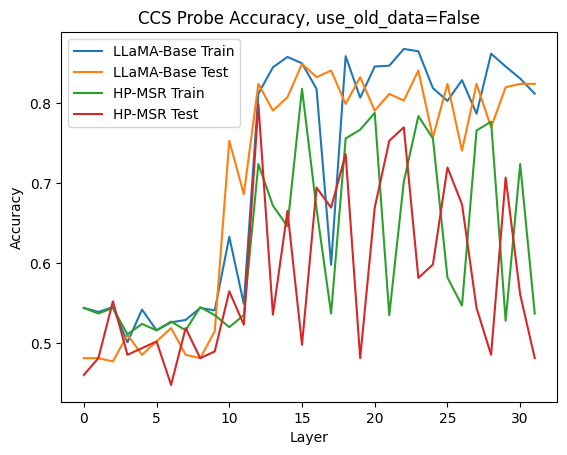

In [21]:
# plot accuracies
plot_base_accs = False
for model_name in cache_models.keys():
    plt.plot(train_accuracies[model_name].values(), label=f"{model_name} Train")
    plt.plot(test_accuracies[model_name].values(), label=f"{model_name} Test")
    # plt.plot(random_accuracies[model_name].values(), label=f"{model_name} Random Test")
    if plot_base_accs:
        plt.axhline(base_accs[model_name], label=f"{model_name} Base Acc", linestyle="--")
    
plt.legend()
plt.xlabel("Layer")
plt.ylabel("Accuracy")
plt.title(f"CCS Probe Accuracy, {use_old_data=}")
# plt.title("Random CCS Probes Accuracy")
plt.show()

In [22]:
with open("results/ccs_accuracies_1239.pkl", "wb") as f:
    pickle.dump({'train_accuracies': train_accuracies, 'test_accuracies': test_accuracies, 'random_accuracies': random_accuracies}, f)

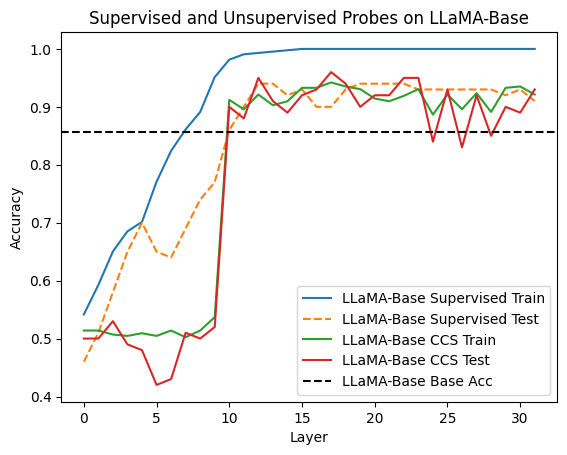

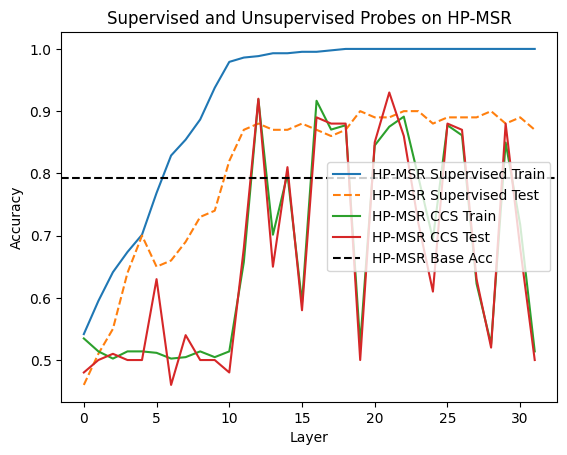

In [26]:
# Graph with everything, both supervised and unsupervised
plot_base_accs = True
for model_name in cache_models.keys():
    plt.plot(train_accs[model_name], label=f"{model_name} Supervised Train", linestyle='-')
    plt.plot(test_accs[model_name], label=f"{model_name} Supervised Test", linestyle='--')

    plt.plot(train_accuracies[model_name].values(), label=f"{model_name} CCS Train")
    plt.plot(test_accuracies[model_name].values(), label=f"{model_name} CCS Test")

    if plot_base_accs:
        plt.axhline(base_accs[model_name], label=f"{model_name} Base Acc", linestyle="--", color='black')

    plt.title(f"Supervised and Unsupervised Probes on {model_name}")
    plt.legend()
    plt.xlabel("Layer")
    plt.ylabel("Accuracy")
    plt.show()